# Matrix Approximation

In [1]:
import torch
import torch.nn as nn
from torch import optim
#from torchdiffeq import odeint_adjoint as odeint
from scipy.linalg import expm
from torchdiffeq import odeint
import numpy as np
import csv
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

### Defining essential functions

In [2]:
def dydt(y, t, A):
    return torch.mm(y,A)

In [37]:
def phi_A(y,A):
    return odeint(lambda t,x : dydt(x,t,A), y, torch.tensor([0., 1.]))[1]

### Neural ODE structure

In [4]:
class ODEFunc(torch.nn.Module):
    def __init__(self, A):
        super(ODEFunc, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A))
        
    def forward(self, t, y):
        return dydt(y, t, self.A)

In [5]:
class NeuralODE(torch.nn.Module):
    def __init__(self, A_init):
        super(NeuralODE, self).__init__()
        self.func = ODEFunc(A_init)
        self.dim=len(A_init)
        self.hidden_layer = torch.nn.Linear(self.dim, 100)
        self.output_layer = torch.nn.Linear(100, self.dim*self.dim)
        
    def forward(self, y):
        y = self.hidden_layer(y)
        y = torch.relu(y)
        y = self.output_layer(y)
        return y
    
    def get_A(self):
        return self.func.A

## Training

In [63]:
def train_model(model, x_data,y_data,epochs=300, lr=0.05):
    training_loss=[]
    y_pred_list = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(model.func, x_data, torch.tensor([0., 1.]), method='dopri5')[1]
        loss = criterion(y_pred, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            #print(f"Epoch {epoch}, Training Loss: {loss:.4f}")
            predict=torch.diag(neural_ode.get_A())
            #print(predict)
            training_loss.append(loss.detach().numpy().item())
            y_pred_list.append(predict.detach().numpy())
    return training_loss,y_pred_list

### Parameters

In [65]:
dim = 10 #dimension of the matrix
mean = 1 #mean of the diagonal values
n_samples=5 #number of samples
stddevs=[i/10 for i in range(1,11)] #standard deviations from 0.1 to 1

file_path = 'data'

In [66]:
#gaussian distribution for the x_i

x_data = torch.randn(n_samples, dim)

In [43]:
""" adding noise to y
stddev=0.05
diag = torch.from_numpy(np.random.normal(loc=mean, scale=stddev, size=dim).astype(np.float32))
A_true = torch.diag(diag)
y_data = phi_A(x_data, A_true)
noise_stddev = stddev/10  
noise = noise_stddev * torch.randn_like(y_data) 
y_noisy = y_data + noise
"""

In [64]:
n_samples_list

[5, 10, 20, 50, 100]

In [67]:
import numpy as np

data = {}

for n_samples in n_samples_list:    
    for stddev in tqdm(stddevs):
        print("déviation standard : ",str(stddev))

        diag = torch.from_numpy(np.random.normal(loc=mean, scale=stddev, size=dim).astype(np.float32))
        A_true = torch.diag(diag)
        print("matrice à viser : " , diag)

        y_data = phi_A(x_data, A_true)

        neural_ode = NeuralODE(np.eye(dim).astype(np.float32))
        training_loss,y_pred_list = train_model(neural_ode, x_data, y_data)
        A_estimated = neural_ode.get_A()
        frob_losses=np.linalg.norm((A_true-A_estimated).detach().numpy())

        key = str(stddev)
        data[key] = {'training_loss': training_loss, 'A_true': diag,'y_pred':y_pred_list,'frob':frob_losses}
        print(data[key])

    np.save(file_path+'_'+str(n_samples), data)

  0%|          | 0/10 [00:00<?, ?it/s]

déviation standard :  0.1
matrice à viser :  tensor([0.9609, 1.0259, 0.9400, 0.8708, 0.9962, 1.1152, 1.0437, 1.0031, 0.8897,
        0.9953])


 10%|█         | 1/10 [00:20<03:00, 20.11s/it]

{'training_loss': [0.03888038545846939, 0.008162330836057663, 0.0010126327397301793, 0.0001430544798495248, 1.5143974451348186e-05, 1.6051020566010266e-06, 3.3824923661995854e-07, 5.2114764059751906e-08, 5.769722921655784e-09, 1.0223542012965936e-09, 1.0085393631342754e-10, 2.369494878085021e-11, 1.8876218296770553e-11, 1.5522260560230094e-11, 1.0109928519352884e-11], 'A_true': tensor([0.9609, 1.0259, 0.9400, 0.8708, 0.9962, 1.1152, 1.0437, 1.0031, 0.8897,
        0.9953]), 'y_pred': [array([0.95000005, 1.05      , 0.95      , 0.95      , 0.9500002 ,
       1.05      , 1.05      , 1.0499998 , 0.95      , 0.9500002 ],
      dtype=float32), array([0.9528388 , 0.9173443 , 0.9475243 , 0.9144807 , 0.94932747,
       1.0232959 , 0.97983927, 0.98650295, 0.9350315 , 0.947615  ],
      dtype=float32), array([0.9502556 , 0.8587691 , 0.9344295 , 0.8832738 , 0.9371604 ,
       1.0000867 , 0.95576733, 0.964256  , 0.92024094, 0.9355819 ],
      dtype=float32), array([0.94097984, 0.8551399 , 0.930685

 20%|██        | 2/10 [00:52<03:39, 27.47s/it]

{'training_loss': [0.38243621587753296, 0.01755322515964508, 0.002422556048259139, 0.0002758472692221403, 2.7795864298241213e-05, 4.863834874413442e-06, 5.833946943312185e-07, 6.509183236858007e-08, 7.2320229804745395e-09, 1.22782717326686e-09, 1.0871823580282935e-10, 2.2927666709637862e-11, 1.9989257644958958e-12, 1.4626444586746112e-12, 3.4682255982063093e-13], 'A_true': tensor([1.0680, 0.7255, 0.8417, 1.3334, 1.0609, 1.3493, 0.9600, 0.8700, 0.9490,
        0.6532]), 'y_pred': [array([1.05      , 0.95      , 0.95      , 1.05      , 1.05      ,
       1.05      , 0.95000005, 0.95      , 0.95      , 0.95      ],
      dtype=float32), array([0.98643863, 0.77685905, 0.91461766, 1.0970474 , 0.9090122 ,
       1.1033447 , 0.9749968 , 0.9218438 , 0.9924902 , 0.87196684],
      dtype=float32), array([0.9630148 , 0.7136653 , 0.8997323 , 1.084107  , 0.87099004,
       1.0905483 , 0.971278  , 0.93104315, 0.99374896, 0.8355314 ],
      dtype=float32), array([0.9566451 , 0.6937925 , 0.8892063 , 1

 30%|███       | 3/10 [01:13<02:50, 24.34s/it]

{'training_loss': [0.5256251692771912, 0.020263411104679108, 0.003126047318801284, 0.00023629004135727882, 4.2999297875212505e-05, 6.44516194370226e-06, 7.628390221725567e-07, 7.955430447736944e-08, 7.559387782407612e-09, 1.3767116335827723e-09, 2.2286358869472167e-10, 3.065268872060045e-11, 2.2565843291189047e-11, 1.8233300286274456e-11, 1.1235849056712155e-11], 'A_true': tensor([1.3064, 1.1241, 1.1184, 1.3519, 0.8518, 0.7972, 1.1879, 1.3449, 1.1971,
        1.5561]), 'y_pred': [array([1.05, 1.05, 1.05, 1.05, 0.95, 0.95, 1.05, 1.05, 1.05, 1.05],
      dtype=float32), array([1.0478146 , 0.9255799 , 1.0203521 , 1.1139903 , 0.91989434,
       0.86506987, 1.0183636 , 1.1220362 , 1.0458959 , 1.0805999 ],
      dtype=float32), array([1.0135139 , 0.8549889 , 1.0132945 , 1.1084492 , 0.85041666,
       0.85205144, 0.9922436 , 1.1215215 , 1.0330275 , 1.0661368 ],
      dtype=float32), array([1.0197865 , 0.8442024 , 1.0135123 , 1.1021243 , 0.8372444 ,
       0.84973735, 0.9895795 , 1.119688  , 1

 40%|████      | 4/10 [01:32<02:12, 22.12s/it]

{'training_loss': [2.4904444217681885, 0.11927399039268494, 0.01400311104953289, 0.0014376159524545074, 0.00013447295350488275, 1.4164997082843911e-05, 2.765723138509202e-06, 4.23182171971348e-07, 3.1755408969047494e-08, 7.3056569682705685e-09, 5.270088809794515e-10, 1.257772080931474e-10, 1.291303695916124e-11, 3.4626134425008726e-12, 3.232426912941344e-12], 'A_true': tensor([1.0032, 0.9593, 0.6827, 1.8627, 1.3134, 1.2669, 1.5524, 1.4093, 1.4498,
        0.1838]), 'y_pred': [array([1.0499997 , 0.95000005, 0.95      , 1.05      , 1.05      ,
       1.05      , 1.05      , 1.05      , 1.05      , 0.95      ],
      dtype=float32), array([0.84013844, 0.82658446, 0.78678334, 1.4538594 , 0.9508214 ,
       1.0602101 , 1.1302853 , 1.1174948 , 1.122107  , 0.7098357 ],
      dtype=float32), array([0.86233115, 0.62354356, 0.75206804, 1.3286254 , 0.89110136,
       1.0393963 , 1.0694399 , 1.1209544 , 1.1332057 , 0.6604968 ],
      dtype=float32), array([0.81591517, 0.57199574, 0.7625763 , 1.359

 50%|█████     | 5/10 [02:01<02:03, 24.70s/it]

{'training_loss': [7.8978376388549805, 0.3364551067352295, 0.02787676639854908, 0.005698725581169128, 0.0006091638351790607, 0.0001190731709357351, 1.0415658834972419e-05, 1.5119845784283825e-06, 1.731804815108262e-07, 1.9446302346182165e-08, 3.284554628280034e-09, 4.587445423531733e-10, 3.4166922763256835e-11, 6.56634425652558e-12, 2.2255242353858007e-12], 'A_true': tensor([0.0130, 1.3450, 1.7437, 2.2950, 0.6000, 1.5113, 0.9296, 0.4804, 0.8702,
        1.8439]), 'y_pred': [array([0.95, 1.05, 1.05, 1.05, 0.95, 1.05, 0.95, 0.95, 0.95, 1.05],
      dtype=float32), array([0.6606741 , 0.9415666 , 1.4730856 , 1.7737558 , 0.81480074,
       1.1714842 , 0.85454774, 0.59804   , 0.8856549 , 1.0386778 ],
      dtype=float32), array([0.38292882, 0.3712485 , 1.3733214 , 1.7120506 , 0.5978394 ,
       1.116944  , 0.8268355 , 0.69917524, 0.8282648 , 1.1190361 ],
      dtype=float32), array([0.32652298, 0.28143054, 1.3560902 , 1.6972659 , 0.53176993,
       1.0981089 , 0.79881126, 0.6533801 , 0.80204

 60%|██████    | 6/10 [02:26<01:39, 24.90s/it]

{'training_loss': [4.51209020614624, 0.13373567163944244, 0.023631634190678596, 0.0021835286170244217, 0.00037772697396576405, 4.364947017165832e-05, 5.2906630116922315e-06, 8.243001730079413e-07, 9.38070456868445e-08, 8.098272274992269e-09, 1.2136702753906548e-09, 3.2966052110339206e-10, 7.322772249684917e-11, 2.2962569345974515e-10, 2.5811064396918937e-10], 'A_true': tensor([ 1.3415,  1.4808,  2.1053,  1.3922,  1.6191, -0.0937,  0.8005,  0.7521,
         1.8313,  0.4043]), 'y_pred': [array([1.05, 1.05, 1.05, 1.05, 1.05, 0.95, 0.95, 0.95, 1.05, 0.95],
      dtype=float32), array([0.9242756 , 1.0401143 , 1.5806991 , 1.154076  , 1.0615245 ,
       0.562864  , 0.92082685, 0.8066105 , 1.2301185 , 0.65881455],
      dtype=float32), array([0.791407 , 0.9227635, 1.5722548, 1.1310917, 1.0684066, 0.5702836,
       0.8115684, 0.7477407, 1.2476399, 0.5021244], dtype=float32), array([0.80937994, 0.9115477 , 1.5220816 , 1.1196548 , 1.0372385 ,
       0.54804766, 0.7722823 , 0.6967613 , 1.226391  ,

 70%|███████   | 7/10 [02:50<01:14, 24.68s/it]

{'training_loss': [2.6232690811157227, 0.07832358777523041, 0.004378471523523331, 0.0008944253786467016, 0.00028415530687198043, 2.7791546017397195e-05, 1.696729214017978e-06, 4.0977528215080383e-07, 3.720618835245659e-08, 5.978175288134935e-09, 1.0667171590483804e-09, 7.39207306477141e-11, 8.509868157369205e-12, 5.682888881697323e-11, 0.00033908328623510897], 'A_true': tensor([0.4454, 1.2961, 0.7276, 0.4791, 0.5368, 0.5453, 2.1019, 0.7305, 0.7348,
        1.0642]), 'y_pred': [array([0.95, 1.05, 0.95, 0.95, 0.95, 0.95, 1.05, 0.95, 0.95, 1.05],
      dtype=float32), array([0.7802409 , 0.919159  , 0.82353264, 0.7365382 , 0.78343004,
       0.7405204 , 1.3777412 , 0.8531378 , 0.91128325, 0.82622886],
      dtype=float32), array([0.7297581 , 0.78888637, 0.76328945, 0.7325263 , 0.7608583 ,
       0.77054334, 1.3141527 , 0.7911795 , 0.89805967, 0.7212021 ],
      dtype=float32), array([0.73697203, 0.77034247, 0.7574425 , 0.72484374, 0.7390208 ,
       0.7496555 , 1.2953242 , 0.78596526, 0.88

 80%|████████  | 8/10 [03:17<00:50, 25.38s/it]

{'training_loss': [4.997604846954346, 0.2531696856021881, 0.022220056504011154, 0.002690155291929841, 0.00032382115023210645, 6.659446080448106e-05, 3.929348167730495e-06, 1.1095431773355813e-06, 9.997658878546645e-08, 1.3849111191177599e-08, 9.743787086335942e-05, 4.428989086591173e-06, 1.8155743930492463e-07, 3.4605633913997735e-08, 5.13835587412359e-08], 'A_true': tensor([1.4186, 2.6136, 0.6110, 1.8938, 1.4044, 1.6677, 0.0759, 0.7120, 1.2899,
        1.3398]), 'y_pred': [array([1.05, 1.05, 0.95, 1.05, 1.05, 1.05, 0.95, 0.95, 1.05, 1.05],
      dtype=float32), array([1.0048085 , 1.6143061 , 0.75471187, 1.4073633 , 0.95540386,
       1.2523726 , 0.7326101 , 0.81148803, 1.0462909 , 0.9239839 ],
      dtype=float32), array([1.0265198 , 1.4348505 , 0.6661609 , 1.3183149 , 0.93148935,
       1.163045  , 0.6609892 , 0.7527411 , 1.0286217 , 0.8997964 ],
      dtype=float32), array([1.0396575 , 1.4384497 , 0.65012336, 1.3204725 , 0.8938149 ,
       1.1617863 , 0.6333057 , 0.73118806, 1.02655

 90%|█████████ | 9/10 [03:38<00:23, 23.88s/it]

{'training_loss': [4.183828830718994, 0.15079765021800995, 0.012951290234923363, 0.0024086812045425177, 0.0002497228852007538, 3.1194322218652815e-05, 4.1389139369130135e-06, 4.0547064372731256e-07, 7.76105295585694e-08, 1.010553241087564e-08, 1.501496149636239e-09, 1.5170874279046842e-10, 1.310604336168808e-08, 0.0007395143038593233, 7.522568921558559e-05], 'A_true': tensor([0.5304, 0.5058, 0.3064, 2.0139, 1.7216, 0.1885, 1.4635, 1.5496, 1.3464,
        0.8055]), 'y_pred': [array([0.95, 0.95, 0.95, 1.05, 1.05, 0.95, 1.05, 1.05, 1.05, 0.95],
      dtype=float32), array([0.69933176, 0.6976589 , 0.6142474 , 1.547815  , 1.0707604 ,
       0.592131  , 1.0855545 , 1.2391678 , 1.106056  , 0.74307877],
      dtype=float32), array([0.7458947 , 0.29918757, 0.6777615 , 1.455765  , 1.0288341 ,
       0.6433782 , 1.0430808 , 1.2141465 , 1.0779446 , 0.72159374],
      dtype=float32), array([0.7016145 , 0.16407213, 0.63398635, 1.4430101 , 1.0015255 ,
       0.61782277, 1.0506017 , 1.2148861 , 1.0721

100%|██████████| 10/10 [03:52<00:00, 23.29s/it]


{'training_loss': [1.8316034078598022, 0.07221650332212448, 0.005337195470929146, 0.0011979166883975267, 0.00015372918278444558, 1.8352415281697176e-05, 2.0175159534119302e-06, 2.303182498053502e-07, 3.1316730542130244e-08, 6.2089089425398925e-09, 4.3291520368526903e-10, 7.46934319950654e-11, 3.527596163621638e-06, 4.8190111556323245e-05, 5.61556953471154e-06], 'A_true': tensor([ 0.7188,  1.6315,  0.4656,  0.6991,  0.5494, -0.0451,  0.2390,  1.7402,
         1.2077,  0.0900]), 'y_pred': [array([0.95, 1.05, 0.95, 0.95, 0.95, 0.95, 0.95, 1.05, 1.05, 0.95],
      dtype=float32), array([0.8073473 , 1.0836817 , 0.7028315 , 0.8985573 , 0.78626794,
       0.5034874 , 0.75593704, 1.4016865 , 1.0438156 , 0.70447737],
      dtype=float32), array([0.75193   , 1.0861452 , 0.74772745, 0.83932406, 0.78224355,
       0.5400285 , 0.7275406 , 1.3336248 , 1.0335135 , 0.6615828 ],
      dtype=float32), array([0.76836985, 1.087923  , 0.73601484, 0.8250958 , 0.76908064,
       0.5681028 , 0.710396  , 1.338

  0%|          | 0/10 [00:00<?, ?it/s]

déviation standard :  0.1
matrice à viser :  tensor([0.7762, 1.2109, 1.0815, 0.8467, 0.9621, 1.0848, 0.7981, 1.0378, 0.9688,
        0.9001])


 10%|█         | 1/10 [00:12<01:50, 12.28s/it]

{'training_loss': [0.06951228529214859, 0.00805987510830164, 0.0011646763887256384, 0.0001388850068906322, 1.7217209460795857e-05, 2.0996128569095163e-06, 2.9302060511327e-07, 3.691442884701246e-08, 5.5193503101236274e-09, 7.430343007541751e-10, 1.3081997984887295e-10, 7.759003856078195e-11, 6.092813059632718e-11, 1.4328396247265118e-08, 0.00041921780211851], 'A_true': tensor([0.7762, 1.2109, 1.0815, 0.8467, 0.9621, 1.0848, 0.7981, 1.0378, 0.9688,
        0.9001]), 'y_pred': [array([0.95      , 1.05      , 1.05      , 0.95      , 0.95000005,
       1.05      , 0.95      , 1.05      , 0.95000005, 0.95      ],
      dtype=float32), array([0.9043535 , 0.92526263, 1.0072316 , 0.8946041 , 0.94393986,
       1.0026165 , 0.9050832 , 0.9967625 , 0.9556888 , 0.93514776],
      dtype=float32), array([0.9040803 , 0.86375064, 0.9992605 , 0.8814018 , 0.937566  ,
       0.98822397, 0.89754486, 0.9719652 , 0.9503166 , 0.924469  ],
      dtype=float32), array([0.8913262 , 0.84274894, 0.99972636, 0.874

 20%|██        | 2/10 [00:35<02:29, 18.65s/it]

{'training_loss': [0.19322139024734497, 0.010510149411857128, 0.001751422300003469, 0.00015660987992305309, 2.6230476578348316e-05, 4.259860361344181e-06, 3.702519393300463e-07, 3.230963940836773e-08, 5.0108686089345156e-09, 7.244536637251997e-10, 1.4566943207228178e-09, 0.00017899196245707572, 2.891621261369437e-05, 1.1748911532549755e-07, 4.812820861843647e-07], 'A_true': tensor([0.9810, 1.0308, 0.9840, 0.8095, 0.4106, 1.1449, 1.1904, 1.2327, 0.9108,
        1.1212]), 'y_pred': [array([0.95000005, 1.05      , 0.95000005, 0.95      , 0.95      ,
       1.05      , 1.05      , 1.05      , 0.95      , 1.05      ],
      dtype=float32), array([0.9823413 , 0.9324651 , 0.9799063 , 0.90173703, 0.8149162 ,
       1.0398699 , 1.0143831 , 1.080542  , 0.94599956, 0.9623525 ],
      dtype=float32), array([0.97041917, 0.8760411 , 0.9726621 , 0.8946885 , 0.76515853,
       1.0198458 , 0.996738  , 1.070671  , 0.93345284, 0.9416907 ],
      dtype=float32), array([0.96775746, 0.86697495, 0.9700316 , 

 30%|███       | 3/10 [01:25<03:50, 32.87s/it]

{'training_loss': [0.35927149653434753, 0.015162069350481033, 0.001954481704160571, 0.00024668651167303324, 2.065740955004003e-05, 3.634050926848431e-06, 4.998069016437512e-07, 8.108649041105309e-08, 8.390375505484826e-09, 1.3736358717153507e-09, 1.9929573269461542e-10, 4.2532515703852525e-11, 2.141366250985044e-11, 1.5889204882379993e-11, 2.3760953274387653e-11], 'A_true': tensor([1.2098, 0.7008, 1.1240, 0.5962, 1.2804, 0.8338, 0.4674, 0.6296, 0.7994,
        1.0262]), 'y_pred': [array([1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 0.95, 0.95, 0.95, 1.05],
      dtype=float32), array([1.0183601 , 0.83032995, 1.0209364 , 0.8194181 , 1.040288  ,
       0.9061598 , 0.8502827 , 0.8660047 , 0.9038163 , 0.99925286],
      dtype=float32), array([1.018627  , 0.813266  , 1.0170345 , 0.79795647, 1.0158056 ,
       0.89974284, 0.8251699 , 0.83433175, 0.89738387, 0.9802399 ],
      dtype=float32), array([1.0168929 , 0.8192789 , 1.0223603 , 0.79859006, 1.0067794 ,
       0.9013845 , 0.8132563 , 0.82500947, 

 40%|████      | 4/10 [02:08<03:41, 36.94s/it]

{'training_loss': [1.6564950942993164, 0.07928278297185898, 0.010984424501657486, 0.001147580100223422, 0.00010181328980252147, 1.1315343726892024e-05, 2.501298467905144e-06, 2.370677947283184e-07, 3.682269067439847e-08, 3.487150568304287e-09, 5.490985999223597e-10, 9.932333427942197e-11, 5.205759087689721e-11, 9.935516818992962e-12, 5.5993751302274575e-11], 'A_true': tensor([0.7757, 0.2175, 0.8602, 1.7990, 0.9778, 0.9963, 0.9593, 1.4355, 0.3450,
        0.8654]), 'y_pred': [array([0.95      , 0.95      , 0.95      , 1.05      , 0.95000005,
       0.95000005, 0.95000005, 1.05      , 0.95      , 0.95      ],
      dtype=float32), array([0.837609  , 0.7316446 , 0.94097257, 1.4346598 , 0.8706139 ,
       0.9746786 , 0.99414575, 1.1471044 , 0.7471427 , 0.9105456 ],
      dtype=float32), array([0.8066552 , 0.58248955, 0.8976293 , 1.332977  , 0.8477132 ,
       0.95346385, 0.951264  , 1.1424946 , 0.70977914, 0.819648  ],
      dtype=float32), array([0.7760114 , 0.5265684 , 0.9109842 , 1.3484

 50%|█████     | 5/10 [02:48<03:11, 38.24s/it]

{'training_loss': [0.8287075757980347, 0.023781156167387962, 0.004804821219295263, 0.00032638368429616094, 8.56811529956758e-05, 9.792898708838038e-06, 8.990038509182341e-07, 1.1488922524449663e-07, 1.1158272528177804e-08, 2.1570789598968076e-09, 4.1052664045970744e-10, 9.943470352657968e-11, 4.784216425801624e-11, 7.117079348972766e-06, 0.00010379905143054202], 'A_true': tensor([0.3786, 1.2324, 1.2422, 0.7439, 0.9404, 0.5315, 0.7636, 0.7266, 1.6425,
        1.1515]), 'y_pred': [array([0.95      , 1.05      , 1.05      , 0.95      , 0.95000005,
       0.95      , 0.95      , 0.95      , 1.05      , 1.05      ],
      dtype=float32), array([0.8006085 , 0.93556124, 1.0454484 , 0.8600389 , 0.904785  ,
       0.78787225, 0.9232662 , 0.8901282 , 1.1854213 , 1.0101892 ],
      dtype=float32), array([0.7335609 , 0.88069564, 1.0362859 , 0.84791446, 0.865723  ,
       0.78009945, 0.8974811 , 0.8722417 , 1.1858302 , 1.0170772 ],
      dtype=float32), array([0.73383486, 0.8635164 , 1.0318831 , 0.

 60%|██████    | 6/10 [03:07<02:06, 31.59s/it]

{'training_loss': [1.2920920848846436, 0.031076857820153236, 0.006524513941258192, 0.000682544952724129, 5.413706458057277e-05, 1.4936768820916768e-05, 1.9026172140002018e-06, 2.1608555300645094e-07, 1.884956368769508e-08, 1.8391392853089883e-09, 3.0091651392893937e-10, 6.61942792246073e-11, 4.4155915902843734e-12, 1.0024358730251204e-12, 8.592562967570105e-13], 'A_true': tensor([0.6320, 0.8732, 0.8747, 0.5394, 1.7692, 1.1392, 1.0355, 1.6734, 0.7824,
        0.3750]), 'y_pred': [array([0.95      , 0.95000005, 0.95      , 0.95      , 1.05      ,
       1.05      , 1.05      , 1.05      , 0.95      , 0.95      ],
      dtype=float32), array([0.8512074 , 0.85157424, 0.9170748 , 0.7672138 , 1.1438428 ,
       1.0190616 , 0.94307053, 1.3310843 , 0.87553173, 0.7724326 ],
      dtype=float32), array([0.7261578, 0.7866565, 0.8748445, 0.7336593, 1.1785944, 0.9898921,
       0.9237163, 1.2911774, 0.8453702, 0.7013581], dtype=float32), array([0.7192844 , 0.7845746 , 0.8640162 , 0.72351575, 1.1571

 70%|███████   | 7/10 [03:51<01:46, 35.48s/it]

{'training_loss': [1.1115800142288208, 0.04799677059054375, 0.004763015545904636, 0.000674902054015547, 6.356232916004956e-05, 9.489689546171576e-06, 1.3564620076067513e-06, 2.029324974728297e-07, 3.001652970624491e-08, 1.814325800708616e-09, 3.5666630759934037e-10, 5.113895418240588e-11, 6.8120344434707825e-12, 1.2343803930392472e-11, 2.219058487309966e-12], 'A_true': tensor([-0.8194,  1.6000,  0.6657, -0.1997,  1.5943,  0.8523,  1.0781,  0.7924,
         0.8845, -0.1696]), 'y_pred': [array([0.95, 1.05, 0.95, 0.95, 1.05, 0.95, 1.05, 0.95, 0.95, 0.95],
      dtype=float32), array([0.52028334, 1.0480721 , 0.80259275, 0.53549635, 1.0929228 ,
       0.9255221 , 0.9904908 , 0.9095004 , 0.92467695, 0.68860406],
      dtype=float32), array([0.5449878 , 1.1102017 , 0.8113986 , 0.5788506 , 1.1066618 ,
       0.947156  , 0.9891782 , 0.90624946, 0.9119435 , 0.67873275],
      dtype=float32), array([0.5414954 , 1.1038972 , 0.8140756 , 0.554099  , 1.1044781 ,
       0.940389  , 0.99071085, 0.90098

 80%|████████  | 8/10 [04:29<01:13, 36.56s/it]

{'training_loss': [4.475965976715088, 0.20694656670093536, 0.021129513159394264, 0.0016820019809529185, 0.00022769547649659216, 4.953495226800442e-05, 6.46772332402179e-06, 6.672665904261521e-07, 6.404192731679359e-08, 8.281051400160777e-09, 1.6037506878063823e-09, 1.701074975324346e-10, 3.5186138724885296e-11, 2.0869759045916147e-11, 1.1403816779775866e-09], 'A_true': tensor([ 1.1082,  2.1790, -0.0449,  0.7824,  1.6360,  0.6875,  0.8629,  1.5977,
         2.1635,  1.7187]), 'y_pred': [array([1.05, 1.05, 0.95, 0.95, 1.05, 0.95, 0.95, 1.05, 1.05, 1.05],
      dtype=float32), array([0.864339  , 1.3036355 , 0.57427627, 0.85020536, 1.0587714 ,
       0.8192032 , 0.8315228 , 1.2235187 , 1.5908009 , 1.0423478 ],
      dtype=float32), array([0.66101027, 1.2561136 , 0.55511254, 0.79455614, 1.0696613 ,
       0.7610518 , 0.771502  , 1.1920196 , 1.3840402 , 1.0769658 ],
      dtype=float32), array([0.62171346, 1.2206584 , 0.5372628 , 0.7648177 , 1.0441618 ,
       0.7514496 , 0.7417541 , 1.18382

 90%|█████████ | 9/10 [05:01<00:35, 35.13s/it]

{'training_loss': [34.88731384277344, 2.4634790420532227, 0.5890486240386963, 0.21588654816150665, 0.0766991451382637, 0.023928193375468254, 0.007914629764854908, 0.0028940800111740828, 0.0009854343952611089, 0.00030709386919625103, 9.097101428778842e-05, 2.5935178200597875e-05, 7.1658087108517066e-06, 1.9131575754727237e-06, 0.0010018812026828527], 'A_true': tensor([ 1.4218,  1.8196,  1.2174,  0.8178,  0.7199,  2.4481,  3.0211,  0.7608,
         0.8373, -0.1054]), 'y_pred': [array([1.05, 1.05, 1.05, 0.95, 0.95, 1.05, 1.05, 0.95, 0.95, 0.95],
      dtype=float32), array([0.85446596, 0.9455025 , 0.98945284, 0.81496185, 0.6932727 ,
       1.64671   , 1.8365113 , 0.7956233 , 0.7363019 , 1.1027036 ],
      dtype=float32), array([0.66216785, 0.7658519 , 0.7732726 , 0.5609658 , 0.40909585,
       1.6787592 , 1.8177209 , 0.5548936 , 0.4057059 , 0.7700972 ],
      dtype=float32), array([0.6247033 , 0.8280045 , 0.7149282 , 0.51890695, 0.34237847,
       1.7286419 , 1.9017385 , 0.571022  , 0.185

100%|██████████| 10/10 [05:24<00:00, 32.48s/it]


{'training_loss': [9.425190925598145, 0.30690810084342957, 0.0328708179295063, 0.004896043334156275, 0.0006502731121145189, 8.306161180371419e-05, 1.0098539860337041e-05, 1.208007688546786e-06, 2.2196067561708333e-07, 3.0740508805138234e-08, 3.6005756154366964e-09, 3.846095941728578e-10, 6.007264130580836e-11, 2.1863377427933095e-11, 3.324908751101141e-11], 'A_true': tensor([ 2.5759,  1.9808,  1.2119, -0.0178,  0.8068,  1.5228,  1.9861,  2.0005,
        -0.6195,  0.7922]), 'y_pred': [array([1.05, 1.05, 1.05, 0.95, 0.95, 1.05, 1.05, 1.05, 0.95, 0.95],
      dtype=float32), array([1.8078022 , 1.1388451 , 1.0767275 , 0.5733027 , 0.72448635,
       1.2218124 , 1.2432876 , 1.5092611 , 0.6275884 , 0.81335497],
      dtype=float32), array([1.6860126 , 1.2592895 , 0.9514786 , 0.5283531 , 0.6155306 ,
       1.1060377 , 1.2132995 , 1.4547849 , 0.51557064, 0.52002096],
      dtype=float32), array([1.6967746 , 1.2102457 , 0.8975998 , 0.48090208, 0.5657584 ,
       1.1012439 , 1.2094121 , 1.444    

  0%|          | 0/10 [00:00<?, ?it/s]

déviation standard :  0.1
matrice à viser :  tensor([0.9002, 1.0157, 0.7729, 1.1010, 0.9952, 0.9447, 1.0289, 0.9913, 1.0883,
        0.9953])


 10%|█         | 1/10 [00:10<01:33, 10.44s/it]

{'training_loss': [0.04590398445725441, 0.010670776478946209, 0.0008875019266270101, 0.00016626360593363643, 2.0281569959479384e-05, 2.8015301722916774e-06, 2.577796180958103e-07, 4.494709315849832e-08, 5.410519587911722e-09, 8.65835680929905e-10, 5.722093632254399e-11, 2.6361877958347435e-11, 2.074500814186475e-11, 2.3444699306929273e-11, 1.4851606056076605e-11], 'A_true': tensor([0.9002, 1.0157, 0.7729, 1.1010, 0.9952, 0.9447, 1.0289, 0.9913, 1.0883,
        0.9953]), 'y_pred': [array([0.95      , 1.0499998 , 0.95      , 1.05      , 0.95000017,
       0.95      , 1.05      , 0.95000005, 1.05      , 0.9500002 ],
      dtype=float32), array([0.94898856, 0.9456259 , 0.8899341 , 0.9973565 , 0.9277721 ,
       0.9701102 , 0.9615347 , 0.9462899 , 1.0175666 , 0.9428604 ],
      dtype=float32), array([0.9447191 , 0.90607476, 0.83681625, 0.99766374, 0.90775555,
       0.9632263 , 0.92240506, 0.93510073, 1.0160434 , 0.9295724 ],
      dtype=float32), array([0.9447707 , 0.90211475, 0.8350124 , 

 20%|██        | 2/10 [00:25<01:43, 12.97s/it]

{'training_loss': [0.4520338475704193, 0.017553452402353287, 0.001714281621389091, 0.0004082249943166971, 3.9606267819181085e-05, 4.90320098833763e-06, 6.116922577348305e-07, 9.956983149095322e-08, 1.1239685626662776e-08, 1.3937854204115752e-09, 1.6597960506015141e-10, 4.073281989480648e-11, 3.535318912617491e-11, 2.1103145272927115e-11, 2.303716592488847e-11], 'A_true': tensor([1.1083, 1.0747, 1.0216, 1.0492, 0.8007, 1.2133, 1.3715, 1.4514, 0.7230,
        0.6855]), 'y_pred': [array([1.05, 1.05, 1.05, 1.05, 0.95, 1.05, 1.05, 1.05, 0.95, 0.95],
      dtype=float32), array([0.9155012, 0.9295681, 0.9585492, 0.9548109, 0.8757647, 1.0590003,
       1.0387679, 1.1372453, 0.8698081, 0.8936857], dtype=float32), array([0.912432  , 0.9240219 , 0.9234995 , 0.95345086, 0.8443186 ,
       1.0519898 , 1.028916  , 1.1553863 , 0.86965466, 0.81680804],
      dtype=float32), array([0.9049988 , 0.91037285, 0.92184204, 0.9480102 , 0.84035385,
       1.0547955 , 1.0226746 , 1.1483122 , 0.8718434 , 0.80552

 30%|███       | 3/10 [00:38<01:32, 13.23s/it]

{'training_loss': [0.6314767599105835, 0.027727777138352394, 0.0032487227581441402, 0.00041118182707577944, 6.165698869153857e-05, 7.188132713054074e-06, 9.743818054630538e-07, 1.4015931526500935e-07, 1.2811772975851454e-08, 2.0204211637064873e-09, 2.6519206275388285e-10, 8.129732997907979e-11, 3.216777066938903e-09, 3.400566129130311e-05, 9.10419771571469e-07], 'A_true': tensor([1.2141, 1.3049, 1.1464, 1.1352, 0.6855, 0.5491, 1.0040, 0.2609, 1.4865,
        1.0574]), 'y_pred': [array([1.05     , 1.05     , 1.05     , 1.05     , 0.95     , 0.95     ,
       1.0499998, 0.95     , 1.05     , 1.05     ], dtype=float32), array([1.0458485 , 0.99834853, 1.0625473 , 1.0206076 , 0.81445616,
       0.79504454, 0.98425704, 0.66348946, 1.1169475 , 0.9799975 ],
      dtype=float32), array([1.0493661 , 0.96317333, 1.0486304 , 1.0161667 , 0.80233073,
       0.7883339 , 0.96629757, 0.67035174, 1.1050757 , 0.9753306 ],
      dtype=float32), array([1.0401498 , 0.94532955, 1.0456444 , 1.0151366 , 0.7969

 40%|████      | 4/10 [00:52<01:20, 13.39s/it]

{'training_loss': [0.40555018186569214, 0.011267236433923244, 0.0015922269085422158, 0.00034590280847623944, 3.3259821066167206e-05, 4.602654826157959e-06, 5.485990755005332e-07, 5.9117539308317646e-08, 1.0302594333211346e-08, 1.3389235276051181e-09, 1.5915178896985793e-10, 2.8233375706787633e-11, 7.93502416551739e-12, 1.4148428088833764e-11, 2.459940237620195e-11], 'A_true': tensor([1.5415, 1.2426, 0.4793, 0.9578, 1.2505, 0.9211, 1.1872, 0.6148, 0.8016,
        1.0618]), 'y_pred': [array([1.05, 1.05, 0.95, 0.95, 1.05, 0.95, 1.05, 0.95, 0.95, 1.05],
      dtype=float32), array([1.1359998 , 0.95905495, 0.74112684, 0.948622  , 1.0100751 ,
       0.94727665, 1.0006053 , 0.83514214, 0.9133517 , 0.9770113 ],
      dtype=float32), array([1.1098413 , 0.91454124, 0.7143692 , 0.9440613 , 0.96791923,
       0.9356711 , 0.9798951 , 0.78873444, 0.8920538 , 0.9608063 ],
      dtype=float32), array([1.089683  , 0.8987776 , 0.7204744 , 0.9425486 , 0.95766926,
       0.93528205, 0.9757595 , 0.77888006

 50%|█████     | 5/10 [01:26<01:44, 20.89s/it]

{'training_loss': [1.1935862302780151, 0.04344378039240837, 0.005665092263370752, 0.0007846824009902775, 0.00010780566663015634, 1.4867468053125776e-05, 1.496051822869049e-06, 1.6099480149023293e-07, 2.376520136238014e-08, 3.3415714639772887e-09, 4.524231544955626e-10, 4.8592747881048837e-11, 1.4604693205910735e-05, 1.9293534933240153e-05, 3.030278321602964e-06], 'A_true': tensor([1.5371, 0.8911, 1.5847, 0.8465, 0.9771, 0.4757, 1.0030, 1.1722, 1.6346,
        0.9979]), 'y_pred': [array([1.05      , 0.95000005, 1.05      , 0.95      , 0.95000005,
       0.95      , 1.0499998 , 1.05      , 1.05      , 0.9500006 ],
      dtype=float32), array([1.091051  , 0.81959313, 1.2441393 , 0.93776554, 0.9357611 ,
       0.745519  , 0.94927984, 1.047896  , 1.2054245 , 0.9130056 ],
      dtype=float32), array([1.0716835 , 0.814164  , 1.1957668 , 0.91537935, 0.87409693,
       0.71577954, 0.9265953 , 0.9985914 , 1.1899474 , 0.84630746],
      dtype=float32), array([1.0590028 , 0.7912406 , 1.2058344 , 0

 60%|██████    | 6/10 [01:44<01:18, 19.75s/it]

{'training_loss': [6.418198108673096, 0.12055036425590515, 0.031178567558526993, 0.004443276673555374, 0.00046965983347035944, 4.0374059608438984e-05, 6.395491709554335e-06, 4.2407364730934205e-07, 7.52055200337054e-08, 1.1842351987922939e-08, 1.2801371074289136e-09, 2.299621604251456e-10, 3.323528605103654e-11, 7.040425100551806e-12, 2.8970617137885624e-12], 'A_true': tensor([1.0161, 0.0254, 0.7421, 1.4717, 0.6626, 2.0044, 1.0215, 1.9252, 1.8823,
        0.9720]), 'y_pred': [array([1.05      , 0.95      , 0.95      , 1.05      , 0.95      ,
       1.05      , 1.05      , 1.05      , 1.05      , 0.95000005],
      dtype=float32), array([0.80634886, 0.49199897, 0.7050335 , 1.1986135 , 0.7710718 ,
       1.4798405 , 0.88665134, 1.5333251 , 1.4450946 , 0.79864717],
      dtype=float32), array([0.67455584, 0.20433101, 0.72756684, 1.1356144 , 0.4830084 ,
       1.4881852 , 0.8228652 , 1.3879123 , 1.3723336 , 0.5485946 ],
      dtype=float32), array([0.6300154 , 0.11071709, 0.68354064, 1.155

 70%|███████   | 7/10 [02:00<00:56, 18.69s/it]

{'training_loss': [11.824780464172363, 0.46513983607292175, 0.06309514492750168, 0.010018100962042809, 0.001146226772107184, 0.00016985695401672274, 1.843492100306321e-05, 2.3395034531858983e-06, 3.3322953640890773e-07, 2.87661894304847e-08, 5.391957103029199e-09, 6.06357131172075e-10, 1.273838812210215e-10, 1.329854421028287e-10, 1.966481560922162e-10], 'A_true': tensor([2.8274, 0.9752, 1.6653, 1.0143, 1.3806, 1.0447, 1.6158, 2.0715, 1.4745,
        1.2385]), 'y_pred': [array([1.05     , 0.9500001, 1.05     , 1.05     , 1.05     , 1.05     ,
       1.05     , 1.05     , 1.05     , 1.05     ], dtype=float32), array([1.8742218 , 0.58355784, 1.3981738 , 0.930106  , 0.9692812 ,
       1.0357867 , 1.0474089 , 1.4573721 , 1.0717779 , 0.9396347 ],
      dtype=float32), array([1.7916529 , 0.46868283, 1.2921336 , 0.9547751 , 0.75935775,
       0.7166005 , 0.9864427 , 1.396311  , 1.1281915 , 0.606131  ],
      dtype=float32), array([1.7517111 , 0.43829638, 1.2240133 , 0.99181026, 0.7059207 ,
  

 80%|████████  | 8/10 [02:15<00:34, 17.44s/it]

{'training_loss': [2.9459073543548584, 0.10664042830467224, 0.018268069252371788, 0.0018752801697701216, 0.00028336243121884763, 2.14899264392443e-05, 2.9228158382466063e-06, 5.765770652033098e-07, 4.859810331936387e-08, 6.5381668967745554e-09, 9.781879750647704e-10, 1.398964000198788e-10, 2.944563690099322e-11, 1.5254733240488427e-11, 3.030839121342943e-11], 'A_true': tensor([-0.7089,  1.1204,  1.4417,  1.4935,  0.9039,  1.5099,  1.3622,  1.2840,
         1.9842,  1.1521]), 'y_pred': [array([0.95, 1.05, 1.05, 1.05, 0.95, 1.05, 1.05, 1.05, 1.05, 1.05],
      dtype=float32), array([0.60987   , 0.7803613 , 1.2275902 , 1.1962836 , 0.77703345,
       1.2299327 , 1.0338917 , 1.066199  , 1.510554  , 0.90888226],
      dtype=float32), array([0.53624725, 0.5627321 , 1.1563882 , 1.2071248 , 0.6694539 ,
       1.181875  , 1.0050546 , 1.0591769 , 1.3521692 , 0.8527823 ],
      dtype=float32), array([0.51751256, 0.49318296, 1.1471385 , 1.1902704 , 0.64277905,
       1.1830263 , 1.0031157 , 1.03998

 90%|█████████ | 9/10 [02:31<00:17, 17.04s/it]

{'training_loss': [1.4564766883850098, 0.07415586709976196, 0.006412413902580738, 0.0007234359509311616, 8.362505468539894e-05, 1.84554355655564e-05, 1.757068730512401e-06, 1.4919697832738166e-07, 3.4471995036255976e-08, 3.115959490429532e-09, 4.4595979686867793e-10, 5.8182583750898687e-11, 3.2014679102188026e-11, 2.467966282726497e-11, 2.8122259729257415e-11], 'A_true': tensor([ 0.3517, -1.0512,  0.8372,  0.7152,  0.0925,  1.6398,  0.5523,  0.8120,
         1.2453,  1.5138]), 'y_pred': [array([0.95, 0.95, 0.95, 0.95, 0.95, 1.05, 0.95, 0.95, 1.05, 1.05],
      dtype=float32), array([0.7686672 , 0.56592685, 0.83686966, 0.85277814, 0.74342525,
       1.2229078 , 0.84686536, 0.8927599 , 1.0759469 , 0.97296757],
      dtype=float32), array([0.7271021 , 0.5226254 , 0.86434865, 0.861371  , 0.66559535,
       1.177769  , 0.80760986, 0.8850678 , 1.043246  , 0.93003976],
      dtype=float32), array([0.73515207, 0.48477158, 0.8657162 , 0.8576368 , 0.6546748 ,
       1.1925516 , 0.7921698 , 0.889

100%|██████████| 10/10 [03:06<00:00, 18.60s/it]


{'training_loss': [4.603399276733398, 0.15158580243587494, 0.012946344912052155, 0.001974110957235098, 0.0003573932044673711, 4.606015863828361e-05, 6.967965873627691e-06, 9.030134151544189e-07, 9.245277965419518e-08, 6.382372852442586e-09, 1.5001905273592797e-09, 2.8409524732708746e-10, 2.93034346787735e-11, 1.4358001766689998e-11, 2.9590468964002525e-11], 'A_true': tensor([ 0.2678,  2.7564,  1.1132,  0.6868, -0.1731,  0.4149,  0.0680,  1.8841,
         0.2999,  0.2979]), 'y_pred': [array([0.95, 1.05, 1.05, 0.95, 0.95, 0.95, 0.95, 1.05, 0.95, 0.95],
      dtype=float32), array([0.7319758 , 1.8613199 , 1.0330819 , 0.87278074, 0.60154694,
       0.6186119 , 0.7380064 , 1.4943067 , 0.7733009 , 0.63914365],
      dtype=float32), array([0.70560473, 1.6913741 , 0.8936591 , 0.77744985, 0.5448951 ,
       0.6837092 , 0.6634915 , 1.4644643 , 0.6553025 , 0.6191758 ],
      dtype=float32), array([0.66150236, 1.7086575 , 0.87314755, 0.7653885 , 0.49419588,
       0.6904841 , 0.6543322 , 1.4273623

  0%|          | 0/10 [00:00<?, ?it/s]

déviation standard :  0.1
matrice à viser :  tensor([1.0751, 1.0956, 1.0259, 1.0403, 1.0438, 1.0905, 1.1029, 0.8383, 1.0336,
        1.0824])


 10%|█         | 1/10 [00:10<01:36, 10.70s/it]

{'training_loss': [0.03872281312942505, 0.011857959441840649, 0.0010148497531190515, 0.0002683734055608511, 2.7161077014170587e-05, 3.804942252827459e-06, 4.919140224046714e-07, 5.004630665439436e-08, 6.859176338025463e-09, 1.1644274433564306e-09, 1.482238221051091e-10, 4.0087225205986954e-11, 4.975583833832786e-11, 2.980917596095978e-11, 5.2604687966750774e-11], 'A_true': tensor([1.0751, 1.0956, 1.0259, 1.0403, 1.0438, 1.0905, 1.1029, 0.8383, 1.0336,
        1.0824]), 'y_pred': [array([1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 0.95, 1.05, 1.05],
      dtype=float32), array([0.9776641 , 0.949652  , 0.97818816, 1.0092525 , 0.96891785,
       1.0418584 , 1.0208464 , 0.87265027, 0.9927164 , 0.98319685],
      dtype=float32), array([0.9596943 , 0.92167073, 0.9602058 , 1.017003  , 0.94500655,
       1.0357252 , 1.0082144 , 0.88617086, 0.9913719 , 0.9751485 ],
      dtype=float32), array([0.95768374, 0.92157066, 0.95581317, 1.0103426 , 0.9457613 ,
       1.0357282 , 1.00356   , 0.876244  , 0

 20%|██        | 2/10 [00:18<01:11,  8.96s/it]

{'training_loss': [0.12796083092689514, 0.008204496465623379, 0.0015288658905774355, 9.756372310221195e-05, 1.753483957145363e-05, 2.7694293294189265e-06, 1.9048331978410715e-07, 1.1853563819386181e-07, 7.254009233292891e-07, 1.869413608801551e-05, 1.093849618882814e-06, 1.8236329779597327e-08, 7.290316972330402e-08, 1.548202135381871e-06, 7.907759709269158e-07], 'A_true': tensor([0.7925, 0.6346, 0.9070, 0.9693, 0.9558, 1.1219, 0.8597, 0.8922, 1.2913,
        0.8431]), 'y_pred': [array([0.95      , 0.95      , 0.95      , 0.95      , 0.95000005,
       1.05      , 0.95      , 0.95      , 1.05      , 0.95      ],
      dtype=float32), array([0.9175092 , 0.79455876, 0.9377827 , 0.9844546 , 0.97513837,
       1.0260278 , 0.93438494, 0.93877983, 1.0959961 , 0.922269  ],
      dtype=float32), array([0.91856605, 0.734333  , 0.9189059 , 0.9753731 , 0.95384574,
       1.0073724 , 0.93071806, 0.93488276, 1.0828028 , 0.9144144 ],
      dtype=float32), array([0.912295  , 0.7278695 , 0.9118583 , 0

 30%|███       | 3/10 [00:34<01:26, 12.32s/it]

{'training_loss': [0.7380686402320862, 0.029683010652661324, 0.0045924405567348, 0.0005058328970335424, 6.193201261339709e-05, 6.874442988191731e-06, 8.289555353258038e-07, 1.2144208483277907e-07, 1.9562255815230856e-08, 1.666153104373791e-09, 1.7841776667193443e-10, 2.2910220595639963e-11, 4.94945534210145e-12, 2.4191638275938843e-12, 6.419618309161379e-12], 'A_true': tensor([0.8799, 1.3278, 1.5472, 0.7389, 1.3493, 0.5806, 1.3901, 1.0203, 0.6778,
        0.9100]), 'y_pred': [array([0.95      , 1.05      , 1.05      , 0.95      , 1.05      ,
       0.95      , 1.05      , 1.05      , 0.95      , 0.95000005],
      dtype=float32), array([0.8914332 , 0.9476995 , 1.2321956 , 0.8144142 , 1.0457832 ,
       0.7987005 , 1.0357037 , 0.95576996, 0.85009795, 0.9401223 ],
      dtype=float32), array([0.8754998 , 0.9636183 , 1.1754059 , 0.80148554, 1.0117584 ,
       0.7750663 , 1.0090331 , 0.9190318 , 0.8217435 , 0.87111837],
      dtype=float32), array([0.86233056, 0.937113  , 1.1884131 , 0.796

 40%|████      | 4/10 [00:49<01:18, 13.08s/it]

{'training_loss': [1.6947450637817383, 0.05224405229091644, 0.004445592872798443, 0.0008526080055162311, 0.00010251272760797292, 1.680209970800206e-05, 2.0844940991082694e-06, 2.3704097884547082e-07, 3.086952915509755e-08, 4.237852291311128e-09, 5.126270519184573e-10, 7.667576990000313e-11, 5.3843340376558135e-12, 3.2097625338872726e-12, 2.8895297612963056e-12], 'A_true': tensor([1.3830, 1.1654, 1.5346, 1.5205, 1.9163, 1.2621, 0.9034, 0.8821, 1.3002,
        1.2951]), 'y_pred': [array([1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 0.95, 0.95, 1.05, 1.05],
      dtype=float32), array([1.0486552 , 0.8066076 , 1.2431512 , 1.2002288 , 1.2194388 ,
       1.0335723 , 0.93005306, 0.90985376, 1.0533458 , 1.0109935 ],
      dtype=float32), array([1.012971  , 0.6675091 , 1.2066231 , 1.1823217 , 1.2141095 ,
       1.0346979 , 0.90934575, 0.8801144 , 0.99257874, 0.98779416],
      dtype=float32), array([1.0042328 , 0.592077  , 1.2081126 , 1.1916249 , 1.2014947 ,
       1.032218  , 0.8976078 , 0.8593254 , 0.

 50%|█████     | 5/10 [01:01<01:04, 12.91s/it]

{'training_loss': [0.613663375377655, 0.020049648359417915, 0.0026747221127152443, 0.00046760012628510594, 4.114651892450638e-05, 7.870926310715731e-06, 7.121991529857041e-07, 9.187229466078861e-08, 1.3951663824229854e-08, 1.9931336581180403e-09, 2.996368431151808e-10, 4.8872347141459827e-11, 1.6679983783074448e-11, 5.2452174548189845e-11, 3.0596910421953893e-11], 'A_true': tensor([1.4197, 1.9061, 1.0658, 0.9271, 0.6966, 1.1974, 0.2959, 0.7488, 0.6904,
        0.6158]), 'y_pred': [array([1.05, 1.05, 1.05, 0.95, 0.95, 1.05, 0.95, 0.95, 0.95, 0.95],
      dtype=float32), array([1.1058092 , 1.192206  , 0.9687769 , 0.9459695 , 0.8716152 ,
       1.0345216 , 0.7859414 , 0.8791858 , 0.85025305, 0.8742382 ],
      dtype=float32), array([1.0647423 , 1.1659822 , 0.9697455 , 0.9508279 , 0.83945197,
       1.0344808 , 0.756521  , 0.8594555 , 0.82134104, 0.83954334],
      dtype=float32), array([1.0451413 , 1.1376657 , 0.9813629 , 0.9506226 , 0.83017385,
       1.0339736 , 0.7544661 , 0.85198414, 

 60%|██████    | 6/10 [01:19<00:58, 14.52s/it]

{'training_loss': [2.3264617919921875, 0.08869372308254242, 0.011766164563596249, 0.001536108087748289, 0.00019145332043990493, 1.5055345102155115e-05, 2.006461954806582e-06, 4.325611371314153e-07, 5.3199922689373125e-08, 7.08526259884934e-09, 6.260310048133988e-10, 1.7305096244868423e-10, 1.4275036708255584e-10, 1.03126146511201e-10, 1.108163838470233e-10], 'A_true': tensor([ 0.4650,  1.5275,  0.2550,  1.7699,  0.0245,  0.1823, -0.0207,  1.3417,
         0.8439, -0.1501]), 'y_pred': [array([0.95, 1.05, 0.95, 1.05, 0.95, 0.95, 0.95, 1.05, 0.95, 0.95],
      dtype=float32), array([0.73177516, 0.96443015, 0.59102714, 1.4354411 , 0.72705936,
       0.5229796 , 0.6993409 , 1.1280535 , 0.91652024, 0.6280897 ],
      dtype=float32), array([0.78983045, 0.92305845, 0.6699672 , 1.3380471 , 0.6642479 ,
       0.60209954, 0.6591245 , 1.1070448 , 0.91079706, 0.6442158 ],
      dtype=float32), array([0.74737996, 0.8750667 , 0.6513768 , 1.3583816 , 0.63623923,
       0.6339634 , 0.6432217 , 1.110944

 70%|███████   | 7/10 [02:00<01:10, 23.35s/it]

{'training_loss': [26.537673950195312, 1.496201992034912, 0.21525251865386963, 0.029009049758315086, 0.004329630173742771, 0.00019546491967048496, 2.2936785171623342e-05, 8.20798595668748e-06, 7.813357001396071e-07, 1.212785178950071e-07, 0.0021899580024182796, 0.00017916444630827755, 1.7740396287990734e-05, 1.0534008652030025e-06, 7.818312042218167e-07], 'A_true': tensor([1.5510, 1.4152, 1.8789, 2.6256, 1.9822, 1.8126, 2.5562, 0.1404, 1.2646,
        2.0183]), 'y_pred': [array([1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 0.95, 1.05, 1.05],
      dtype=float32), array([0.922306 , 1.024395 , 1.3398048, 1.813907 , 1.1891577, 1.2112476,
       1.4809892, 0.5715638, 1.0017216, 1.0850962], dtype=float32), array([0.8302087 , 0.67420536, 1.3500917 , 1.8517413 , 0.9173462 ,
       1.2092392 , 1.4351285 , 0.42302427, 0.9597719 , 0.89512277],
      dtype=float32), array([0.8856654 , 0.49062076, 1.3322732 , 1.8421577 , 0.90727824,
       1.1488285 , 1.3850216 , 0.35626835, 0.90272576, 0.89662033],


 80%|████████  | 8/10 [02:23<00:46, 23.27s/it]

{'training_loss': [20.297260284423828, 1.1604615449905396, 0.43357428908348083, 0.25737664103507996, 0.17072050273418427, 0.11390264332294464, 0.07225921750068665, 0.042711805552244186, 0.023169822990894318, 0.011355508118867874, 0.004951102193444967, 0.0018959221197292209, 0.0006322760600596666, 0.0001829943066695705, 4.601989348884672e-05], 'A_true': tensor([ 1.5041,  1.5322,  0.9045,  1.5876,  0.0994,  2.6340,  0.3693,  0.7007,
         1.2562, -0.1336]), 'y_pred': [array([1.05, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 0.95, 1.05, 0.95],
      dtype=float32), array([1.1229248 , 0.8037208 , 0.8753935 , 1.1465838 , 0.7161874 ,
       1.8935195 , 0.58913   , 0.42902228, 0.87838274, 0.9662074 ],
      dtype=float32), array([0.7317773 , 0.3659628 , 0.61190015, 1.212608  , 0.39788643,
       1.8783011 , 0.2535845 , 0.25767466, 0.5973769 , 0.64226687],
      dtype=float32), array([0.5717907 , 0.11330258, 0.51540923, 1.2356738 , 0.21718433,
       1.8540214 , 0.15274759, 0.45517886, 0.5959038 , 

 90%|█████████ | 9/10 [02:54<00:25, 25.47s/it]

{'training_loss': [2.383025884628296, 0.07884541153907776, 0.012800672091543674, 0.0012491168454289436, 0.00022827606881037354, 2.4534165277145803e-05, 3.7975132727297023e-06, 2.47240024009443e-07, 3.897493527915685e-08, 6.064798885319078e-09, 8.243475346780826e-10, 1.1615591821723115e-10, 2.9755080344084917e-11, 9.662441680102773e-11, 4.3609001826316884e-11], 'A_true': tensor([ 1.6427,  0.9517,  1.7691,  0.4281, -0.9180,  0.3183,  0.6788,  0.3793,
        -1.2934,  1.3205]), 'y_pred': [array([1.05      , 0.95000005, 1.05      , 0.95      , 0.95      ,
       0.95      , 0.95      , 0.95      , 0.95      , 1.05      ],
      dtype=float32), array([1.1338387 , 0.77943265, 1.3984616 , 0.6951442 , 0.5509395 ,
       0.6852623 , 0.91553384, 0.7361292 , 0.4513425 , 1.0524395 ],
      dtype=float32), array([1.1194052 , 0.77497196, 1.3192221 , 0.7613345 , 0.5383875 ,
       0.73700595, 0.87265146, 0.65738124, 0.40132073, 1.0011607 ],
      dtype=float32), array([1.1034871 , 0.8115581 , 1.3087

100%|██████████| 10/10 [03:25<00:00, 20.59s/it]


{'training_loss': [5.329371452331543, 0.15158098936080933, 0.01677127182483673, 0.002864713314920664, 0.00038822542410343885, 4.789619197254069e-05, 5.157100531505421e-06, 9.927068731485633e-07, 9.725720673259275e-08, 8.634962078701847e-09, 1.22931542723137e-09, 2.2062682236700937e-10, 3.3895067308442606e-11, 5.138425275552638e-12, 1.373708351931624e-11], 'A_true': tensor([ 2.1137,  0.5641,  0.9979, -0.0232,  0.6833,  0.7378,  2.1595,  0.8473,
         1.8727,  1.3810]), 'y_pred': [array([1.05     , 0.95     , 0.9500002, 0.95     , 0.95     , 0.95     ,
       1.05     , 0.95     , 1.05     , 1.05     ], dtype=float32), array([1.4715015 , 0.5240493 , 0.92851657, 0.5332387 , 0.7513813 ,
       0.85063124, 1.4046328 , 0.8053402 , 1.3588936 , 0.9730959 ],
      dtype=float32), array([1.3694998 , 0.17772715, 0.7817413 , 0.5479538 , 0.72475576,
       0.7736191 , 1.2870188 , 0.73174334, 1.3307929 , 0.8672042 ],
      dtype=float32), array([1.370978  , 0.13272496, 0.78928363, 0.55060107, 0.6

  0%|          | 0/10 [00:00<?, ?it/s]

déviation standard :  0.1
matrice à viser :  tensor([1.0722, 0.8225, 1.1335, 0.8010, 0.9639, 0.9659, 0.9481, 0.8994, 0.8185,
        0.9343])


 10%|█         | 1/10 [00:13<01:59, 13.28s/it]

{'training_loss': [0.06955622881650925, 0.007684457115828991, 0.0008452610927633941, 8.450345922028646e-05, 1.869144762167707e-05, 2.5312747311545536e-06, 3.3922265174624044e-07, 3.767042500157913e-08, 4.346385473752434e-09, 6.762042037422589e-10, 7.55208326430612e-11, 1.1084100651204132e-11, 3.875462017272069e-12, 2.9384641421492663e-12, 1.6604060704139556e-07], 'A_true': tensor([1.0722, 0.8225, 1.1335, 0.8010, 0.9639, 0.9659, 0.9481, 0.8994, 0.8185,
        0.9343]), 'y_pred': [array([1.05      , 0.95000005, 1.05      , 0.95      , 0.95000005,
       0.95      , 0.95      , 0.95      , 0.95      , 0.95000005],
      dtype=float32), array([0.9986745 , 0.86724174, 1.0207248 , 0.88571835, 0.96455747,
       0.98453087, 0.9676844 , 0.9215478 , 0.90184444, 0.9431354 ],
      dtype=float32), array([0.97302896, 0.8601683 , 1.0129485 , 0.8852652 , 0.9398659 ,
       0.97779703, 0.96093255, 0.9183971 , 0.89078   , 0.9274127 ],
      dtype=float32), array([0.96967006, 0.8520943 , 1.0155977 , 0

 20%|██        | 2/10 [00:20<01:18,  9.87s/it]

{'training_loss': [0.31734490394592285, 0.015725649893283844, 0.0018613977590575814, 0.00019077006436418742, 3.622538861236535e-05, 4.477093625609996e-06, 5.6143949223042e-07, 5.529640034751537e-08, 7.363975207397289e-09, 9.839895565022516e-10, 1.7416755537791317e-10, 2.7298807311892936e-11, 8.276875712587284e-12, 1.2351484418582359e-11, 7.833904419385362e-06], 'A_true': tensor([0.7522, 1.0692, 0.4892, 0.6794, 0.5997, 0.7972, 0.7130, 0.9291, 1.2175,
        0.9735]), 'y_pred': [array([0.95      , 1.05      , 0.95      , 0.95      , 0.95      ,
       0.95      , 0.95      , 0.95      , 1.05      , 0.95000005],
      dtype=float32), array([0.88900846, 0.88900363, 0.7316747 , 0.8679634 , 0.85475636,
       0.9143013 , 0.90715814, 0.9395487 , 1.0554646 , 0.9292539 ],
      dtype=float32), array([0.89411455, 0.8373537 , 0.7663657 , 0.8538383 , 0.84449303,
       0.9039498 , 0.9005756 , 0.9328593 , 1.0253267 , 0.91216105],
      dtype=float32), array([0.8931421 , 0.82992023, 0.7598522 , 0.8

 30%|███       | 3/10 [00:34<01:21, 11.69s/it]

{'training_loss': [0.8437941074371338, 0.03636972978711128, 0.005550260655581951, 0.0005505323642864823, 8.396035264013335e-05, 7.73253123043105e-06, 7.036622378109314e-07, 1.7534578944378154e-07, 1.797885218479678e-08, 9.008808699029203e-10, 1.9982337562396424e-07, 0.00021275786275509745, 2.2018604795448482e-05, 4.279309905541595e-06, 7.690429697504442e-07], 'A_true': tensor([0.7577, 0.6989, 0.7330, 0.8330, 1.1335, 0.5722, 1.6781, 0.5880, 0.6330,
        1.1423]), 'y_pred': [array([0.95      , 0.95000005, 0.95      , 0.95      , 1.05      ,
       0.95      , 1.05      , 0.95      , 0.95      , 1.05      ],
      dtype=float32), array([0.91150576, 0.75616395, 0.87812126, 0.8855347 , 0.9802761 ,
       0.8346966 , 1.1052256 , 0.8123385 , 0.87494165, 0.9598329 ],
      dtype=float32), array([0.9048333 , 0.7155492 , 0.8581595 , 0.8741947 , 0.95539296,
       0.797688  , 1.0761743 , 0.7733081 , 0.8494187 , 0.94472444],
      dtype=float32), array([0.89830095, 0.7023146 , 0.84832746, 0.872

 40%|████      | 4/10 [00:48<01:15, 12.66s/it]

{'training_loss': [1.0123724937438965, 0.032602500170469284, 0.004786977078765631, 0.0003159651532769203, 6.291999306995422e-05, 1.24967473311699e-05, 1.6069697039711173e-06, 1.508175841991033e-07, 2.6522775087300943e-08, 2.2580812775174763e-09, 2.6966484600876583e-10, 1.0800894206797196e-10, 5.953491866161897e-11, 6.079078906928714e-11, 1.007813261821866e-05], 'A_true': tensor([0.7141, 0.5992, 1.2354, 1.0969, 1.8117, 0.7136, 1.1164, 0.6328, 1.3145,
        1.6938]), 'y_pred': [array([0.95, 0.95, 1.05, 1.05, 1.05, 0.95, 1.05, 0.95, 1.05, 1.05],
      dtype=float32), array([0.84316945, 0.7231888 , 1.0568844 , 0.98199385, 1.1547112 ,
       0.84368   , 0.9847986 , 0.8127619 , 1.0922238 , 1.067203  ],
      dtype=float32), array([0.79415023, 0.66001886, 1.0593636 , 0.955169  , 1.1600074 ,
       0.80614936, 0.96188825, 0.7672531 , 1.0640595 , 1.0605451 ],
      dtype=float32), array([0.7941447 , 0.6518265 , 1.0629392 , 0.9486439 , 1.1438128 ,
       0.80042225, 0.9552091 , 0.7678781 , 1.0

 50%|█████     | 5/10 [01:17<01:32, 18.59s/it]

{'training_loss': [1.4335113763809204, 0.05576483905315399, 0.00835861824452877, 0.0008542584837414324, 9.470629447605461e-05, 1.5451161743840203e-05, 1.1762033409468131e-06, 2.813178525684634e-07, 2.374801688631578e-08, 3.768494405420597e-09, 4.1080722157360583e-10, 8.575269661026397e-11, 1.9254866798212866e-11, 1.7699676793658803e-11, 1.3400535889274146e-11], 'A_true': tensor([0.5922, 1.2764, 1.6138, 0.1606, 0.3354, 1.2424, 0.1245, 1.0358, 1.5782,
        0.8575]), 'y_pred': [array([0.95, 1.05, 1.05, 0.95, 0.95, 1.05, 0.95, 1.05, 1.05, 0.95],
      dtype=float32), array([0.7704651 , 0.8792698 , 1.3276362 , 0.58630335, 0.774556  ,
       1.0488783 , 0.7729055 , 0.9747221 , 1.1799812 , 0.87354267],
      dtype=float32), array([0.7638099, 0.9221493, 1.2211838, 0.6663396, 0.7481776, 1.0606109,
       0.7254726, 0.9410277, 1.1792117, 0.8265637], dtype=float32), array([0.7429018 , 0.8921845 , 1.2425468 , 0.63115185, 0.72712445,
       1.0543603 , 0.7198974 , 0.9467909 , 1.1789991 , 0.81368

 60%|██████    | 6/10 [01:47<01:29, 22.29s/it]

{'training_loss': [12.91109848022461, 0.3512495458126068, 0.08428661525249481, 0.019784171134233475, 0.006551734171807766, 0.002715803449973464, 0.0010510756401345134, 0.0003590230771806091, 0.0001080081274267286, 2.8150239813840017e-05, 6.253289939195383e-06, 1.1547313079063315e-06, 1.703831742361217e-07, 1.854408004930974e-08, 1.2440053431816978e-09], 'A_true': tensor([ 2.0784,  0.9381,  0.6655,  0.3356,  0.2921,  1.7728, -0.4624,  1.1420,
         2.6466,  0.4871]), 'y_pred': [array([1.05      , 0.95000005, 0.95      , 0.95      , 0.95      ,
       1.05      , 0.95      , 1.05      , 1.05      , 0.95      ],
      dtype=float32), array([1.3588016 , 0.91587394, 0.6671288 , 0.64015347, 0.9431245 ,
       1.2875544 , 0.68013287, 0.9598285 , 1.8987496 , 0.5142333 ],
      dtype=float32), array([1.2260971 , 0.70391446, 0.45939454, 0.61707526, 0.685206  ,
       1.3578997 , 0.62629586, 0.8560021 , 1.936411  , 0.203429  ],
      dtype=float32), array([1.2725667 , 0.6131096 , 0.43536952, 0

 70%|███████   | 7/10 [02:06<01:03, 21.11s/it]

{'training_loss': [0.8510822057723999, 0.03168218955397606, 0.004255014006048441, 0.000853269943036139, 0.00012457383854780346, 1.265431728825206e-05, 1.1934567964999587e-06, 1.4230913336632511e-07, 2.5106887235892827e-08, 2.752880368106503e-09, 4.958430332990815e-10, 4.508997689112171e-11, 5.340986333757236e-12, 8.41357257301556e-13, 1.1736341321011423e-06], 'A_true': tensor([ 0.9328,  1.0255,  1.0818, -0.2438, -0.2880,  0.7900,  1.0933,  1.4143,
         1.1052,  0.6548]), 'y_pred': [array([0.95, 1.05, 1.05, 0.95, 0.95, 0.95, 1.05, 1.05, 1.05, 0.95],
      dtype=float32), array([0.91014344, 0.92410725, 1.009304  , 0.456147  , 0.6728751 ,
       0.9023059 , 0.9863992 , 1.1429665 , 1.0448452 , 0.8905598 ],
      dtype=float32), array([0.9257603 , 0.964769  , 1.0025346 , 0.52320373, 0.6596289 ,
       0.90740687, 0.9992209 , 1.1286432 , 1.0310819 , 0.82451785],
      dtype=float32), array([0.93316084, 0.99277407, 1.0131217 , 0.54178405, 0.66266596,
       0.9081277 , 1.0004257 , 1.11614

 80%|████████  | 8/10 [02:32<00:45, 22.75s/it]

{'training_loss': [10.652486801147461, 0.6399741172790527, 0.04582781344652176, 0.008740631863474846, 0.0007904810481704772, 0.0001627594610909, 1.3835391655447893e-05, 2.5519384507788345e-06, 1.7608654445666616e-07, 3.4323285547088744e-08, 4.955671428774622e-09, 1.697856411020382e-09, 1.7216990499946405e-08, 0.014877238310873508, 0.001081170397810638], 'A_true': tensor([ 1.2593,  3.2168,  1.7873,  1.9637, -0.3110,  0.1232,  0.8273,  0.6039,
         1.2226,  0.8167]), 'y_pred': [array([1.05, 1.05, 1.05, 1.05, 0.95, 0.95, 0.95, 0.95, 1.05, 0.95],
      dtype=float32), array([0.63030195, 1.9605054 , 1.4232339 , 1.538373  , 0.80966145,
       0.5674371 , 0.84342045, 0.65081465, 1.087327  , 0.7035839 ],
      dtype=float32), array([0.91229445, 1.9407842 , 1.3738195 , 1.4511724 , 0.5733451 ,
       0.54066664, 0.64089614, 0.8225537 , 0.90687096, 0.6999513 ],
      dtype=float32), array([0.83237964, 1.9447663 , 1.3555926 , 1.4752903 , 0.5251075 ,
       0.49528074, 0.56731737, 0.7567468 , 0

 90%|█████████ | 9/10 [02:52<00:21, 21.82s/it]

{'training_loss': [1.6971397399902344, 0.044302068650722504, 0.00963792484253645, 0.001110148266889155, 0.00017644086619839072, 1.6132633390952833e-05, 1.2673007176999818e-06, 1.4395051550764038e-07, 1.2191213372148013e-08, 3.3753360106913988e-09, 4.699169942057324e-10, 8.878375118426263e-11, 1.2081792163942673e-11, 6.031805697276349e-12, 5.668662587943185e-12], 'A_true': tensor([ 1.5215,  1.8055,  1.0282,  1.1660,  1.2068, -1.7699,  1.1500,  0.9157,
        -0.4576,  1.3041]), 'y_pred': [array([1.05, 1.05, 1.05, 1.05, 1.05, 0.95, 1.05, 0.95, 0.95, 1.05],
      dtype=float32), array([1.1557906, 1.1384791, 0.9668913, 1.0520251, 1.034323 , 0.4782801,
       1.0146589, 0.8875041, 0.6120883, 1.0215447], dtype=float32), array([1.1500074 , 1.1477492 , 0.9896811 , 1.0470409 , 1.0228152 ,
       0.44933882, 1.0023271 , 0.8874254 , 0.5998531 , 1.0582514 ],
      dtype=float32), array([1.1287718 , 1.1381096 , 1.0044782 , 1.047101  , 1.0393431 ,
       0.4561334 , 0.99720305, 0.8857491 , 0.583607

100%|██████████| 10/10 [03:13<00:00, 19.31s/it]

{'training_loss': [15.630785942077637, 0.5912455320358276, 0.07819218933582306, 0.010599534958600998, 0.001145179383456707, 0.00012765012797899544, 2.3448770662071183e-05, 3.2886548524402315e-06, 3.2474326872034e-07, 4.529875141656703e-08, 4.6702850475810465e-09, 6.262571017323637e-10, 2.2620050277311066e-10, 9.871472389511027e-11, 9.872577755309919e-11], 'A_true': tensor([ 0.8695, -0.2336,  1.4060,  1.9999,  0.7419,  2.1645,  1.9836, -0.6790,
         2.4277,  0.4787]), 'y_pred': [array([0.95, 0.95, 1.05, 1.05, 0.95, 1.05, 1.05, 0.95, 1.05, 0.95],
      dtype=float32), array([0.7281072 , 0.6522136 , 1.049574  , 1.5643027 , 0.84514385,
       1.562034  , 1.1718013 , 0.42812124, 1.7813975 , 0.6658181 ],
      dtype=float32), array([0.5903989 , 0.12012772, 0.91944385, 1.5137434 , 0.31021056,
       1.6487513 , 1.2599512 , 0.4189044 , 1.7116326 , 0.42284432],
      dtype=float32), array([ 0.53952837, -0.01431417,  0.9697986 ,  1.5179417 ,  0.24163921,
        1.5738481 ,  1.2376795 ,  0.3

# Loading and plotting data

## n_samples = 100

In [53]:
#loading the data trained
n_samples=100
if os.path.exists(file_path+'_'+str(n_samples)+'.npy'):
    data = np.load(file_path+'_'+str(n_samples)+'.npy', allow_pickle=True).item() 

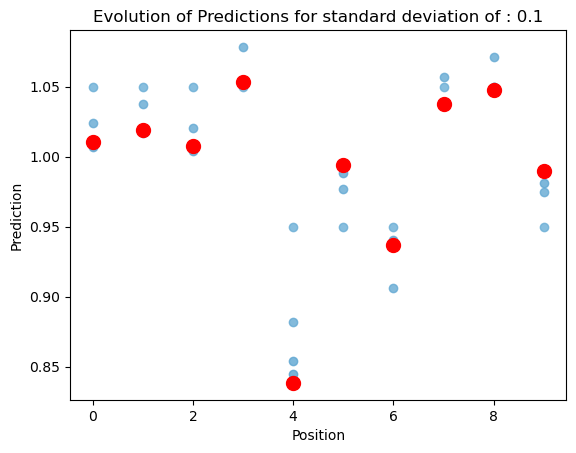

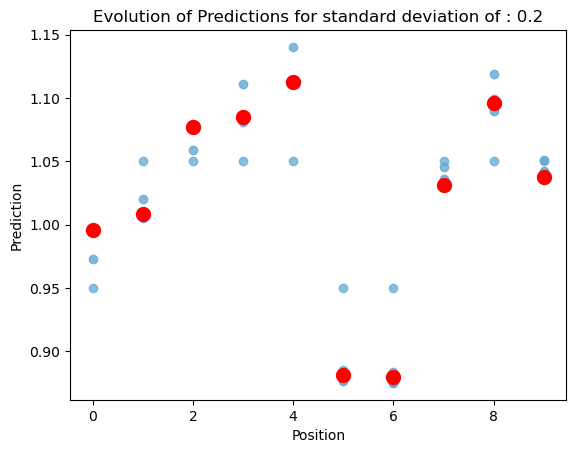

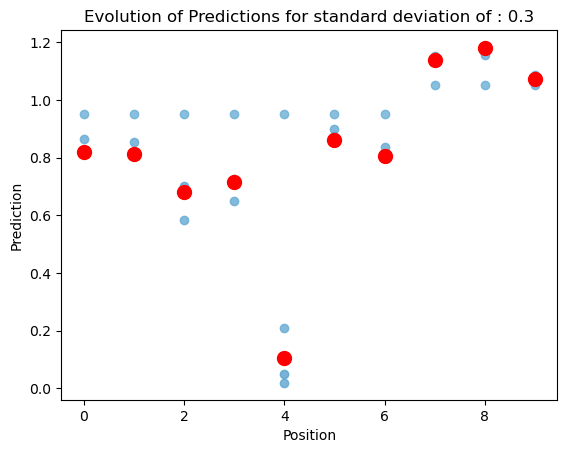

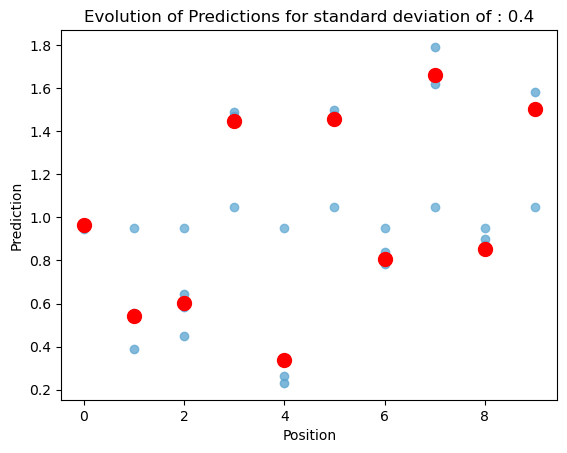

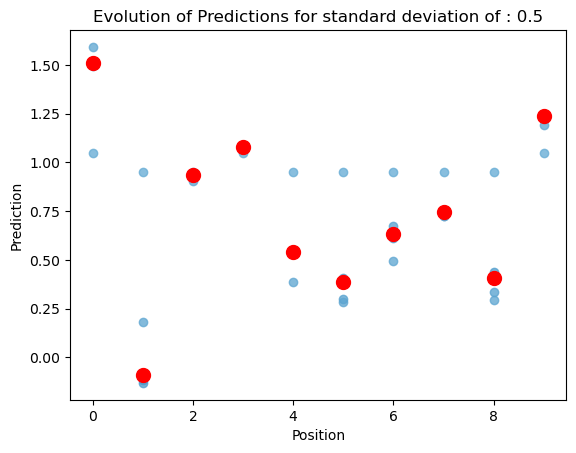

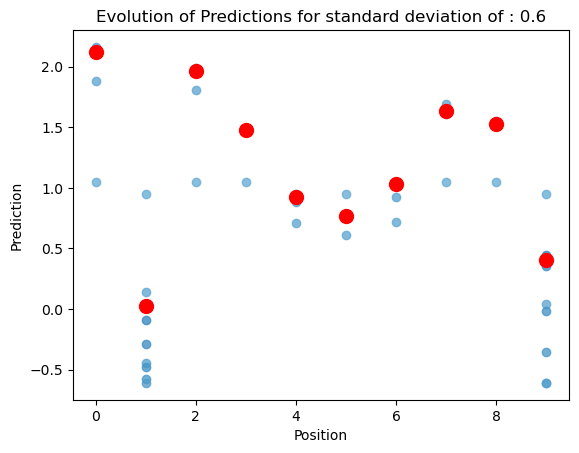

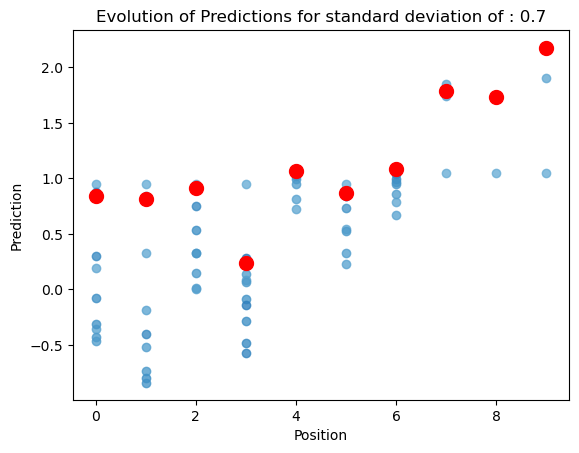

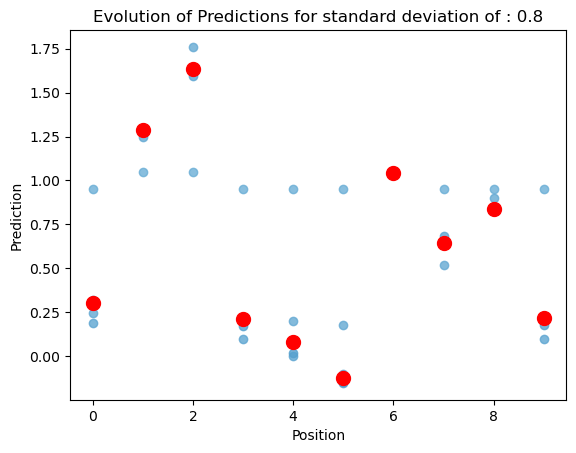

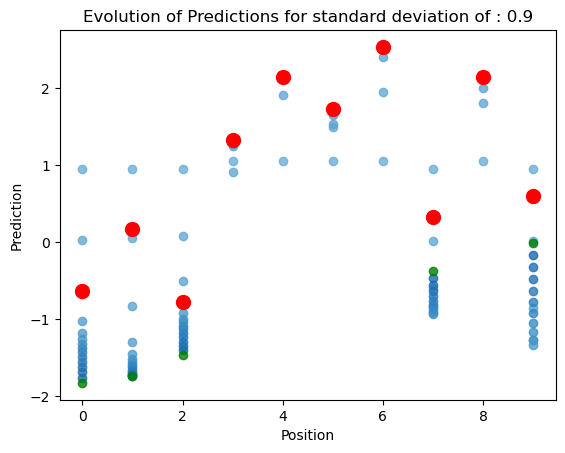

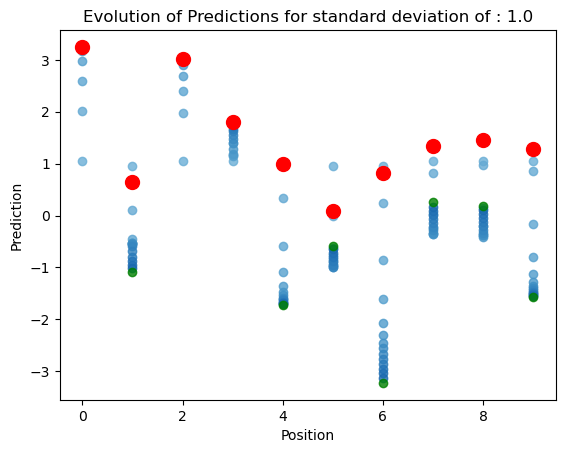

In [16]:
for stddev in stddevs:
    stddev=str(stddev)
    pred_array = data[stddev]['A_true']
    pred_list = data[stddev]['y_pred']

    # Generate the color gradient for pred_list
    colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(pred_list)))
    last_color='green'
    
    # Plot each float in pred_array
    plt.scatter(range(len(pred_array)), pred_array, color='red', s=100)
    
    # Plot each prediction array
    for i, prediction in enumerate(pred_list):
        color = colors[i]
        if i == len(pred_list) - 1:
            color = last_color
        plt.scatter(range(len(prediction)), prediction, color=color, alpha=0.8)

    

    # Set axis labels and title
    plt.xlabel('Position')
    plt.ylabel('Prediction')
    plt.title('Evolution of Predictions for standard deviation of : ' + str(stddev))

    # Show the plot
    plt.show()

## Graph of losses

### Error loss

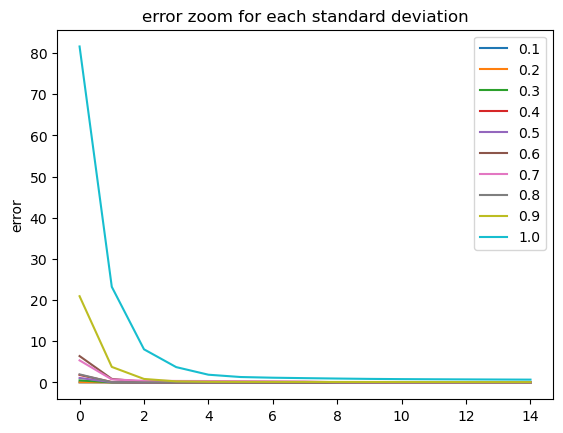

In [17]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.legend()
plt.show()

<b>Zooming</b>

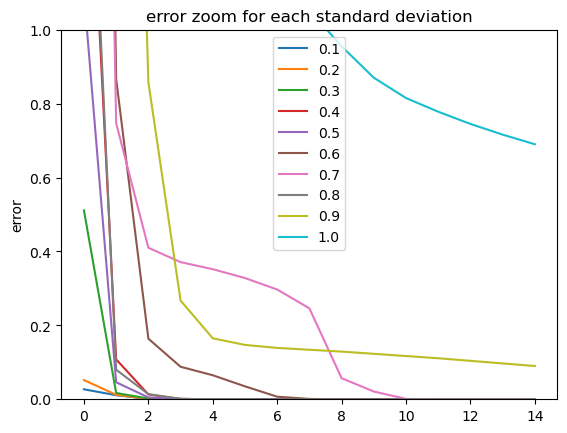

In [18]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.ylim(0,1)
plt.legend()
plt.show()

### Frobenius loss

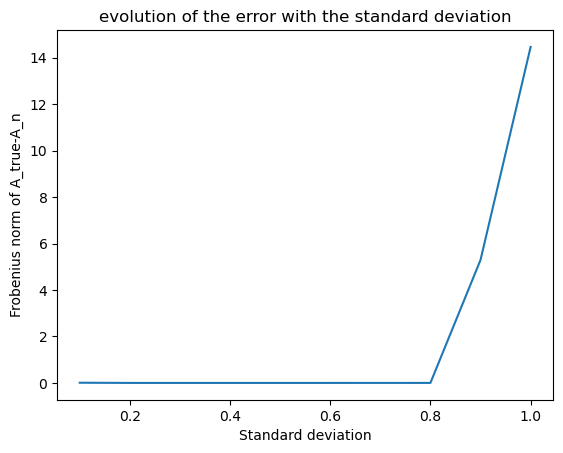

In [19]:
keys = stddevs
values = [data[str(stddev)]['frob'] for stddev in stddevs]

plt.plot(keys, values)
plt.title("evolution of the error with the standard deviation")
plt.xlabel('Standard deviation')
plt.ylabel('Frobenius norm of A_true-A_n')
plt.show()

## n_samples = 10

In [20]:
#loading the data trained
n_samples=10
if os.path.exists(file_path+'_'+str(n_samples)+'.npy'):
    data = np.load(file_path+'_'+str(n_samples)+'.npy', allow_pickle=True).item() 

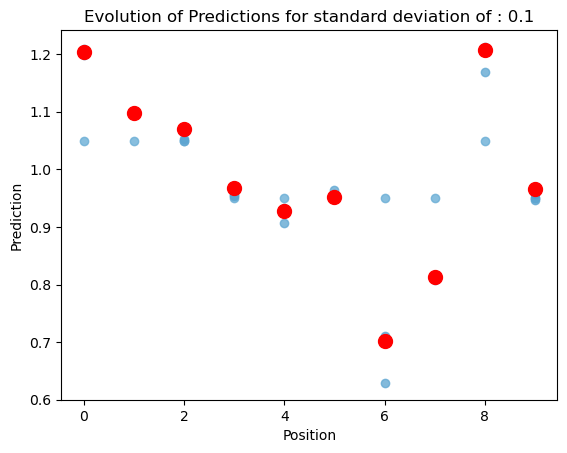

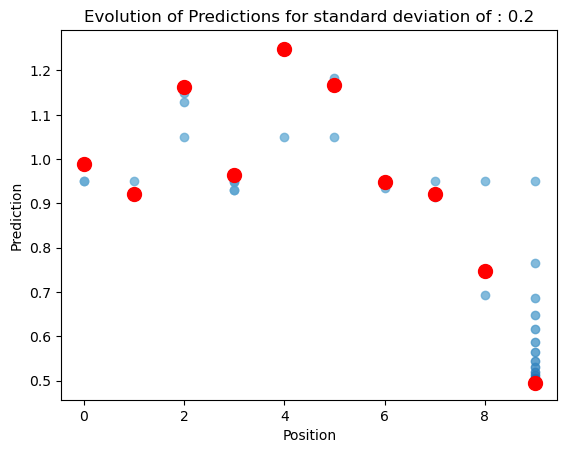

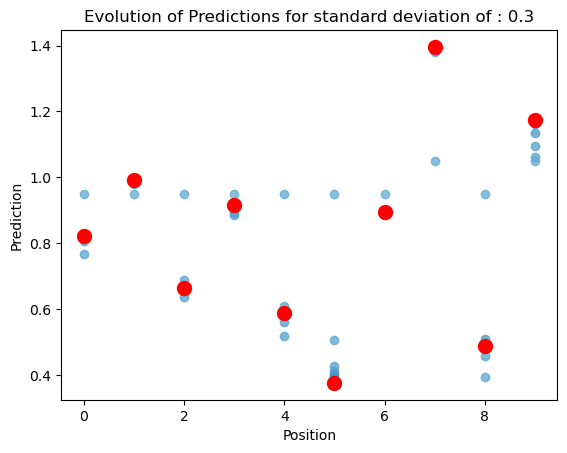

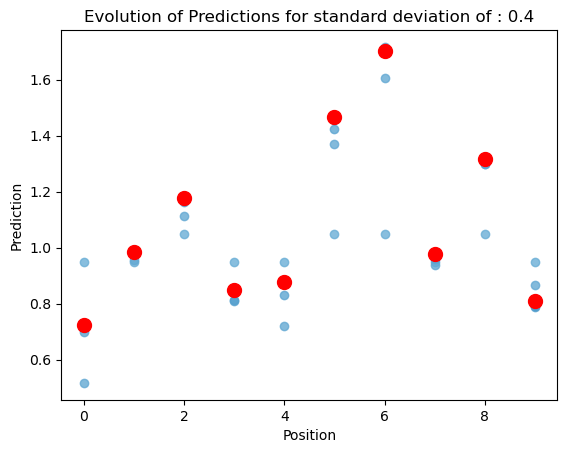

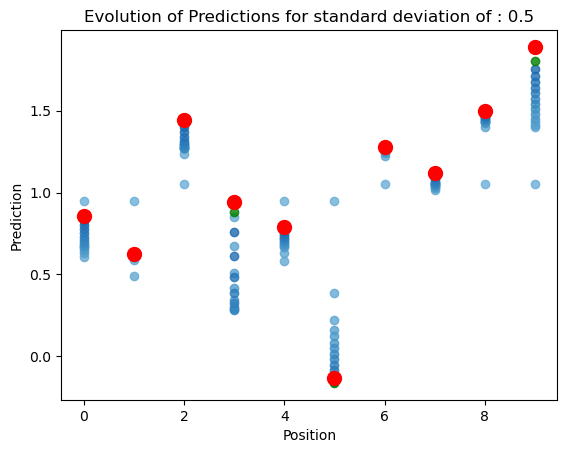

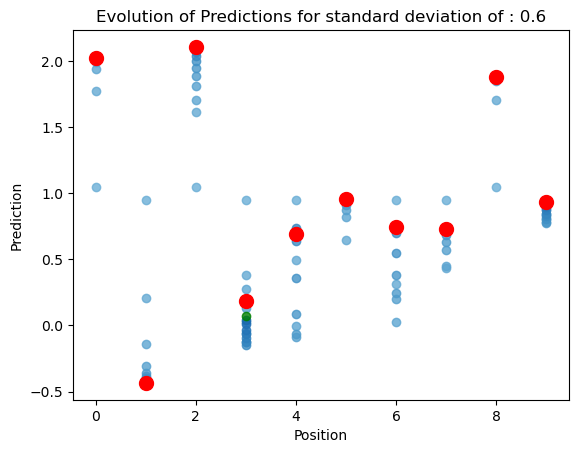

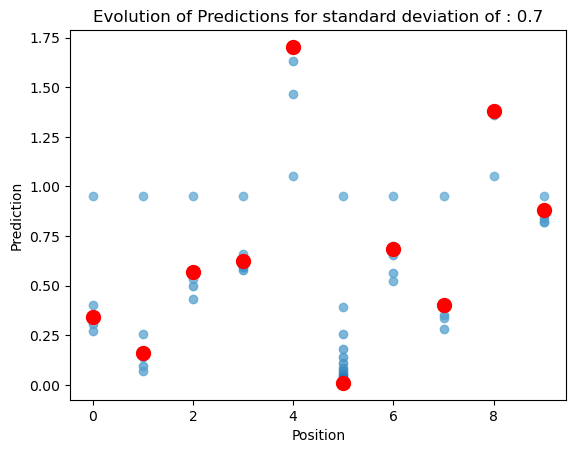

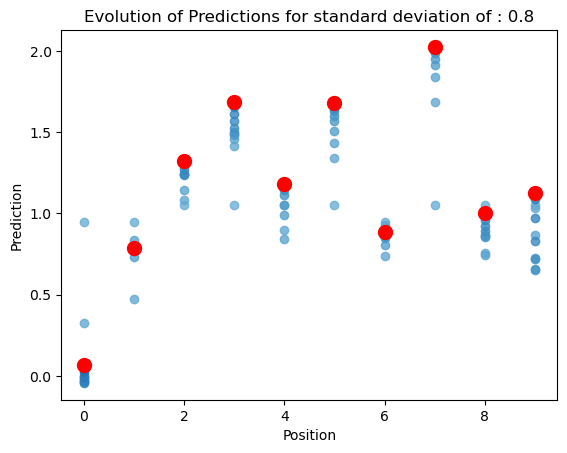

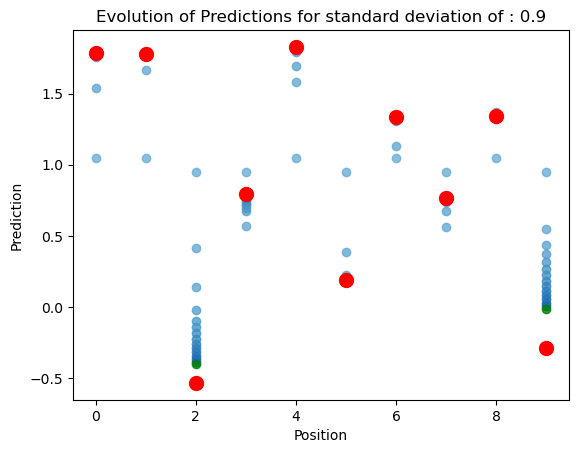

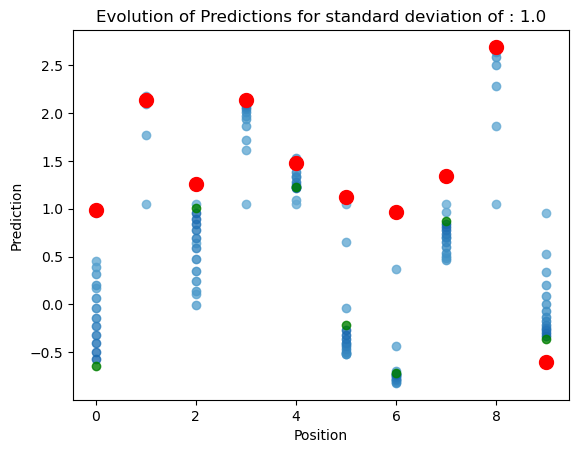

In [21]:
for stddev in stddevs:
    stddev=str(stddev)
    pred_array = data[stddev]['A_true']
    pred_list = data[stddev]['y_pred']

    # Generate the color gradient for pred_list
    colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(pred_list)))
    last_color='green'

    # Plot each prediction array
    for i, prediction in enumerate(pred_list):
        color = colors[i]
        if i == len(pred_list) - 1:
            color = last_color
        plt.scatter(range(len(prediction)), prediction, color=color, alpha=0.8)

    # Plot each float in pred_array
    plt.scatter(range(len(pred_array)), pred_array, color='red', s=100)

    # Set axis labels and title
    plt.xlabel('Position')
    plt.ylabel('Prediction')
    plt.title('Evolution of Predictions for standard deviation of : ' + str(stddev))

    # Show the plot
    plt.show()

## Graph of losses

### Error loss

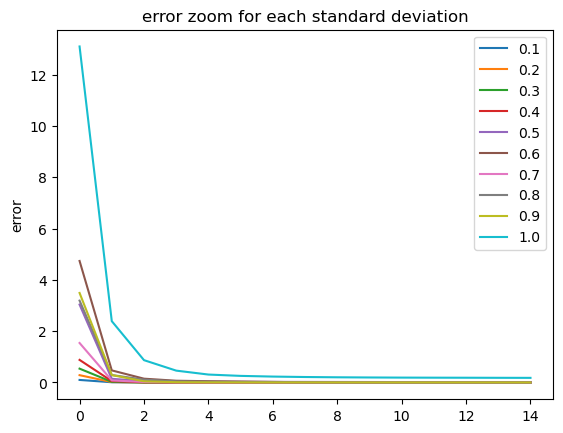

In [22]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.legend()
plt.show()

<b>Zooming</b>

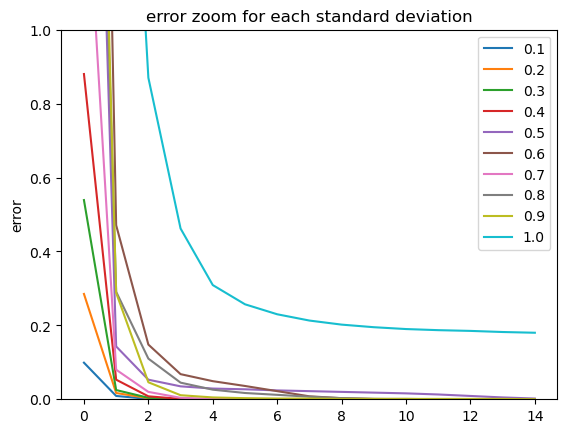

In [23]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.ylim(0,1)
plt.legend()
plt.show()

### Frobenius loss

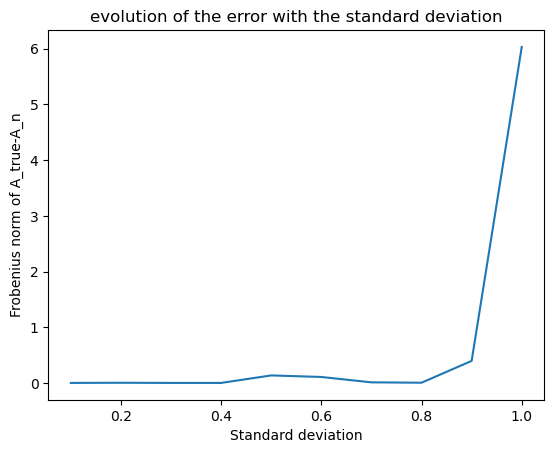

In [24]:
keys = stddevs
values = [data[str(stddev)]['frob'] for stddev in stddevs]

plt.plot(keys, values)
plt.title("evolution of the error with the standard deviation")
plt.xlabel('Standard deviation')
plt.ylabel('Frobenius norm of A_true-A_n')
plt.show()

## n_samples = 5

In [48]:
#loading the data trained
n_samples=5
if os.path.exists(file_path+'_'+str(n_samples)+'.npy'):
    data = np.load(file_path+'_'+str(n_samples)+'.npy', allow_pickle=True).item() 

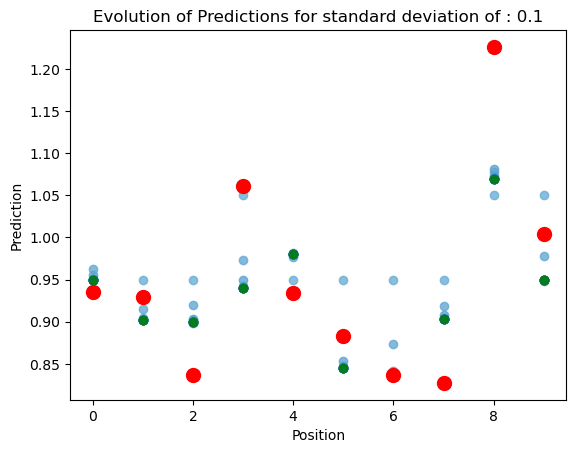

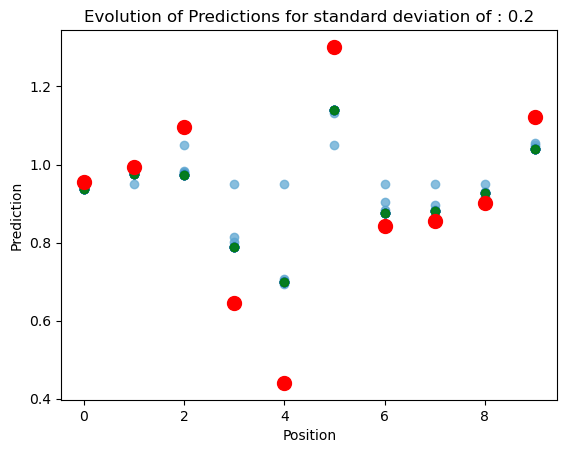

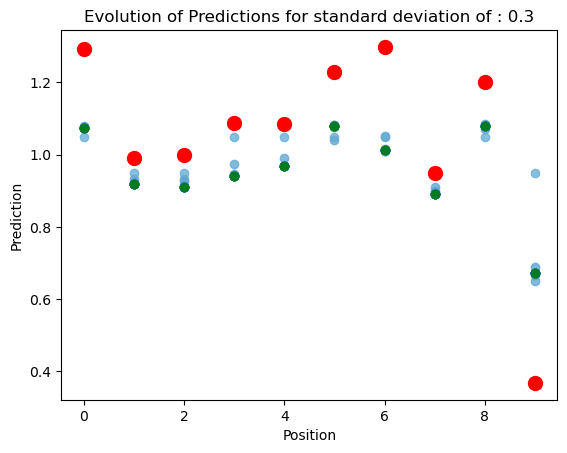

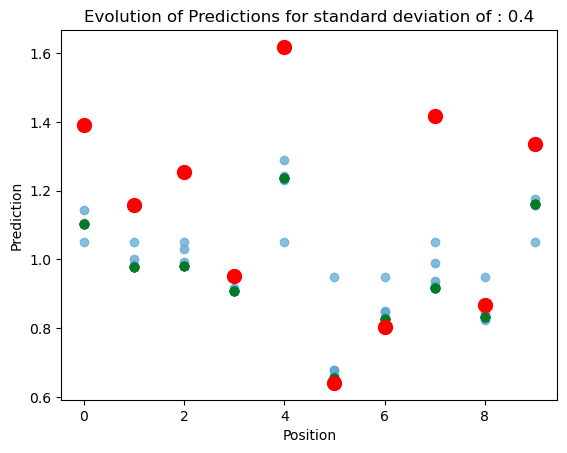

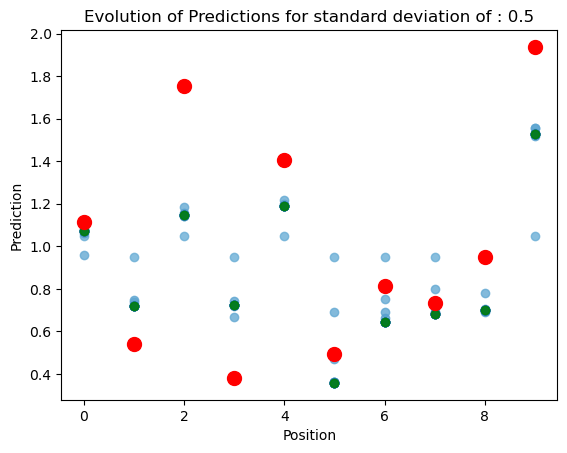

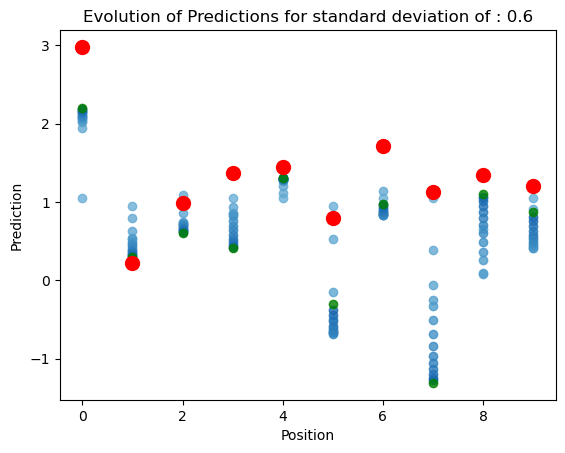

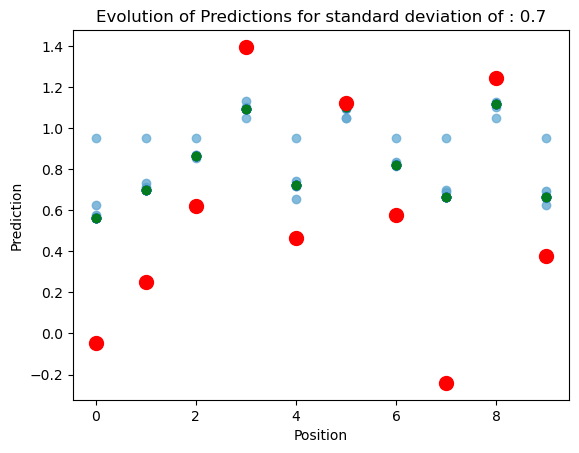

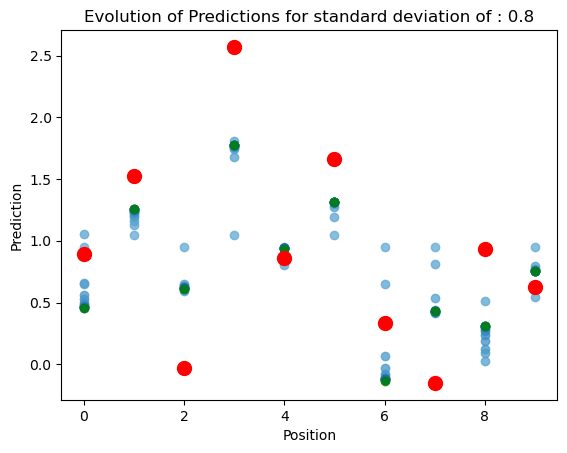

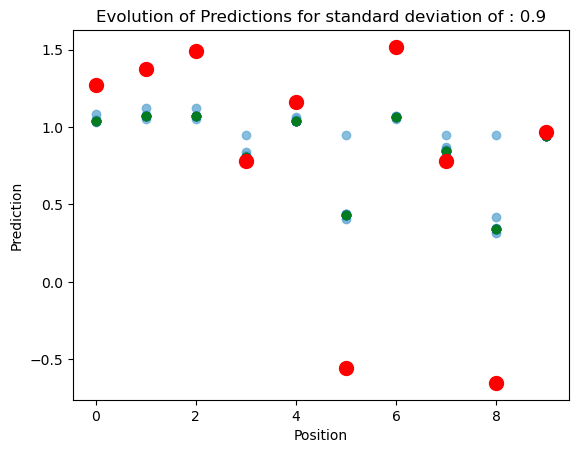

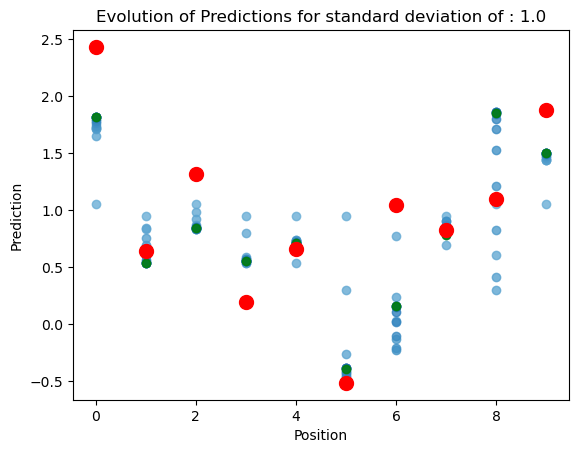

In [49]:
for stddev in stddevs:
    stddev=str(stddev)
    pred_array = data[stddev]['A_true']
    pred_list = data[stddev]['y_pred']

    # Generate the color gradient for pred_list
    colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(pred_list)))
    last_color='green'

    # Plot each prediction array
    for i, prediction in enumerate(pred_list):
        color = colors[i]
        if i == len(pred_list) - 1:
            color = last_color
        plt.scatter(range(len(prediction)), prediction, color=color, alpha=0.8)

    # Plot each float in pred_array
    plt.scatter(range(len(pred_array)), pred_array, color='red', s=100)

    # Set axis labels and title
    plt.xlabel('Position')
    plt.ylabel('Prediction')
    plt.title('Evolution of Predictions for standard deviation of : ' + str(stddev))

    # Show the plot
    plt.show()

## Graph of losses

### Error loss

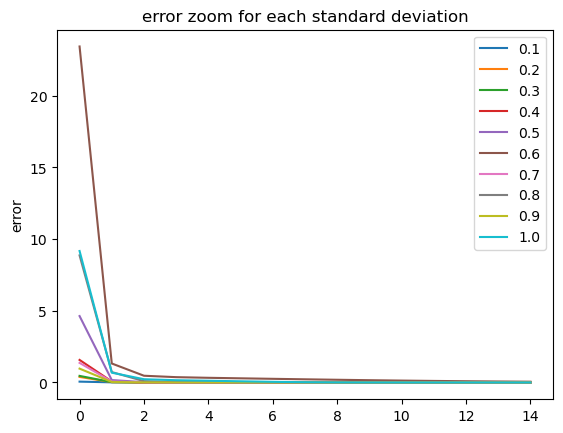

In [50]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.legend()
plt.show()

<b>Zooming</b>

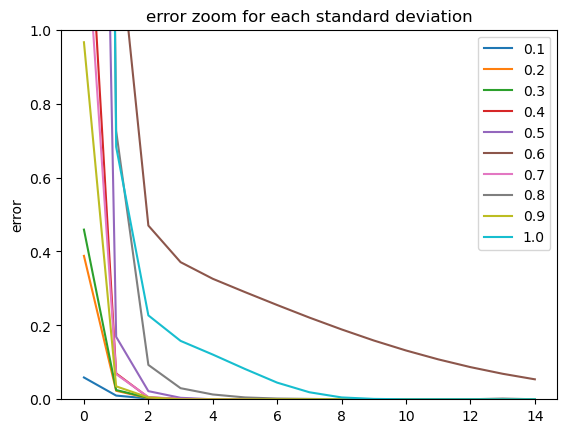

In [51]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.ylim(0,1)
plt.legend()
plt.show()

### Frobenius loss

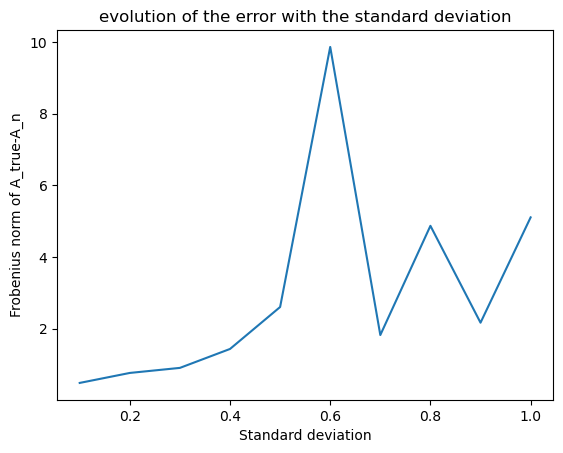

In [52]:
keys = stddevs
values = [data[str(stddev)]['frob'] for stddev in stddevs]

plt.plot(keys, values)
plt.title("evolution of the error with the standard deviation")
plt.xlabel('Standard deviation')
plt.ylabel('Frobenius norm of A_true-A_n')
plt.show()

## Vision log(MSE)

In [88]:
n_samples_list=[5,10,20,50,100]
mse={'5':{},
    '10':{},
    '20':{},
    '50':{},
    '100':{}}

for n_samples in n_samples_list:
    if os.path.exists(file_path+'_'+str(n_samples)+'.npy'):
        data = np.load(file_path+'_'+str(n_samples)+'.npy', allow_pickle=True).item()
        for stddev in stddevs:
            key=str(stddev)
            mse[str(n_samples)][key]=np.log(np.array(data[key]['frob']))

In [101]:
stddev='0.2'
errors={'5':{},
    '10':{},
    '20':{},
    '50':{},
    '100':{}}

for n_samples in n_samples_list:
    errors[str(n_samples)] = mse[str(n_samples)][stddev]

In [110]:
errors

{'5': -0.029286943,
 '10': -0.18159671,
 '20': 0.09934304,
 '50': -0.4792562,
 '100': -0.07514468}

-0.0011024245588428382


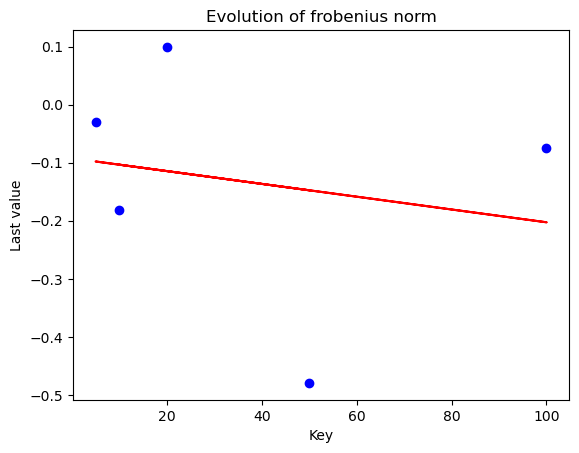

In [119]:
from scipy.stats import linregress

last_vals = [errors[key] for key in sorted(errors.keys())]
keys = sorted(errors.keys())
x = [float(k) for k in keys]

plt.plot(x, last_vals, 'bo')

slope, intercept, r_value, p_value, std_err = linregress(x, list(last_vals))


plt.plot(x, intercept + slope*np.array(x), 'r', label='fitted line')
print(slope)

# Add labels and title
plt.xlabel('Key')
plt.ylabel('Last value')
plt.title('Evolution of frobenius norm')

# Show the plot
plt.show()